In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
import wfdb
import re
from math import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

In [25]:
sample_size=5000

# Read source for create a dataset of annotations
Source : https://physionet.org/content/butqdb/1.0.0/

In [26]:
# Create concatenated dataset with annotation & added informations for all patients
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb') # Save the list of ECG file names
dataannall = pd.DataFrame(columns=header_list) 
for rcd in record_list:
    # Look for each patient the annotation file
    #print(rcd)
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name, end="\r")
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannall = pd.concat([dataannall,dataann.assign(record=rcd.split('/')[0])], ignore_index=True)
#Add columns to dataset : record, signal length, number of samples of 5000 data, filter with not null value in label columns
dataannall['signal_length']=dataannall['end'] - dataannall['start'] 
dataannall["sample"]=round(dataannall["signal_length"]/sample_size)
dataset = dataannall[dataannall["class"].notnull() & dataannall["start"].notnull() & dataannall["end"].notnull() ]


In [27]:
dataset.shape

(7154, 15)

In [28]:
dataset.head()

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
0,1.0,198867.0,2.0,1.0,19525.0,1.0,1,7047,2,1.0,7047.0,2.0,100001,7046.0,1.0
1,198868.0,320282.0,1.0,19526.0,28694.0,2.0,7048,17209,1,7048.0,17209.0,1.0,100001,10161.0,2.0
2,320283.0,373109.0,2.0,28695.0,32739.0,1.0,17210,28390,2,17210.0,28694.0,2.0,100001,11484.0,2.0
3,373110.0,2197974.0,1.0,32740.0,96699.0,2.0,28391,32653,1,28695.0,32653.0,1.0,100001,3958.0,1.0
4,2197975.0,2582746.0,2.0,96700.0,110564.0,1.0,32654,71061,2,32654.0,112474.0,2.0,100001,79820.0,16.0


In [29]:
dataset.describe()

,start1,end1,class1,start2,end2,class2,start,end,class,signal_length,sample
count,2.076000e+03,2.076000e+03,2076.000000,4.305000e+03,4.305000e+03,4305.000000,7.154000e+03,7.154000e+03,7154.000000,7.154000e+03,7154.000000
mean,5.735894e+07,5.817328e+07,1.748073,5.950179e+07,5.987307e+07,1.572590,5.601431e+07,5.625521e+07,1.604417,2.409030e+05,48.144255
std,3.225315e+07,3.202552e+07,0.731805,3.072217e+07,3.057915e+07,0.603114,2.802337e+07,2.796447e+07,0.609641,2.530322e+06,506.072488
min,1.000000e+00,1.988670e+05,0.000000,1.000000e+00,1.952500e+04,0.000000,1.000000e+00,7.047000e+03,0.000000,3.020000e+02,0.000000
25%,2.961164e+07,2.970962e+07,1.000000,3.180192e+07,3.216237e+07,1.000000,3.405290e+07,3.411941e+07,1.000000,2.264250e+03,0.000000
50%,5.676074e+07,5.760000e+07,2.000000,5.791413e+07,5.792801e+07,2.000000,5.507225e+07,5.570303e+07,2.000000,5.853000e+03,1.000000
75%,7.522529e+07,7.664065e+07,2.000000,7.722608e+07,7.766738e+07,2.000000,6.858724e+07,6.945778e+07,2.000000,1.982150e+04,4.000000
max,1.391201e+08,1.391470e+08,3.000000,1.391468e+08,1.391470e+08,3.000000,1.391201e+08,1.391470e+08,3.000000,7.464800e+07,14930.000000


In [30]:
dataset.sort_values(by=['signal_length']).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
2164,29830121.0,29843829.0,2.0,29833497.0,29842799.0,2.0,29041071,29041373,2,29041071.0,29041373.0,2.0,104001,302.0,0.0
6902,NaN,NaN,NaN,NaN,NaN,NaN,22772239,22806837,1,42187296.0,42187599.0,2.0,111001,303.0,0.0
14215,57653762.0,57664665.0,1.0,29052794.0,29058124.0,1.0,28815944,28816279,1,28871845.0,28872149.0,1.0,121001,304.0,0.0
1961,29896114.0,29909814.0,1.0,29430978.0,29432026.0,2.0,29201971,29203041,2,29367658.0,29367979.0,2.0,103003,321.0,0.0
14982,NaN,NaN,NaN,65811759.0,65824014.0,3.0,58413007,58414129,1,65500416.0,65500737.0,2.0,124001,321.0,0.0
15543,57711177.0,57779132.0,1.0,29622202.0,29624040.0,1.0,28902711,29014385,1,29637312.0,29637634.0,1.0,126001,322.0,0.0
2087,NaN,NaN,NaN,NaN,NaN,NaN,29712177,29713943,2,29974330.0,29974654.0,2.0,103003,324.0,0.0
1347,NaN,NaN,NaN,29422321.0,29423807.0,2.0,2.95904e+07,2.95909e+07,2,29583767.0,29584095.0,2.0,100002,328.0,0.0
15582,NaN,NaN,NaN,57917191.0,57917810.0,2.0,57655491,57655835,2,58410626.0,58410956.0,2.0,126001,330.0,0.0
14943,NaN,NaN,NaN,65570247.0,65579982.0,1.0,58189527,58190516,2,65289466.0,65289798.0,2.0,124001,332.0,0.0


In [31]:
dataannall.sort_values(by=['sample'],ascending=False).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
14558,NaN,NaN,NaN,NaN,NaN,NaN,29981332,29991362,2,58800001.0,133448000.0,0.0,123001,74647999.0,14930.0
14419,NaN,NaN,NaN,NaN,NaN,NaN,58497423,58499060,1,58800001.0,122798000.0,0.0,122001,63997999.0,12800.0
2299,1.0,47323379.0,3.0,1.0,47323871.0,3.0,1,47323500,3,1.0,47323500.0,3.0,105001,47323499.0,9465.0
15596,NaN,NaN,NaN,58407654.0,58408005.0,2.0,57821475,57824016,2,58800001.0,92361000.0,0.0,126001,33560999.0,6712.0
13716,57600001.0,58800000.0,1.0,29389929.0,29392545.0,2.0,28903735,28905450,2,58800001.0,91651000.0,0.0,114001,32850999.0,6570.0
14375,NaN,NaN,NaN,NaN,NaN,NaN,58662590,58670947,1,58800001.0,91233000.0,0.0,121001,32432999.0,6487.0
13539,NaN,NaN,NaN,NaN,NaN,NaN,36544236,36546336,1,58800001.0,91148000.0,0.0,113001,32347999.0,6470.0
14073,NaN,NaN,NaN,58800001.0,89091000.0,0.0,58102368,58112099,2,58800001.0,89091000.0,0.0,118001,30290999.0,6058.0
13892,NaN,NaN,NaN,NaN,NaN,NaN,58398360,58401557,1,58800001.0,87934000.0,0.0,115001,29133999.0,5827.0
1512,1.0,28800000.0,0.0,1.0,28800000.0,0.0,1,28800000,0,1.0,28800000.0,0.0,103001,28799999.0,5760.0


In [33]:
dataset.record.unique()

array(['100001', '100002', '103001', '103002', '103003', '104001',
       '105001', '111001', '113001', '114001', '115001', '118001',
       '121001', '122001', '123001', '124001', '125001', '126001'],
      dtype=object)

In [40]:
#plt.hist(dataset['class'], bins=10);
#plt.show()

In [41]:
fig = px.histogram(dataset, x="class", nbins=10)
fig.show()

In [43]:
fig = px.histogram(dataset, x="sample", nbins=10)
fig.show()

In [44]:
dataannall.dtypes

start1           float64
end1             float64
class1           float64
start2           float64
end2             float64
class2           float64
start3            object
end3              object
class3            object
start            float64
end              float64
class            float64
record            object
signal_length    float64
sample           float64
dtype: object

In [45]:
fig = px.histogram(dataannall[dataannall['sample'] < 10]['sample'], nbins=10)
fig.show()

In [46]:
pie_chart_data = dataset[dataset['record'] == '100001'].groupby('class')['sample'].sum()
pie_chart_data.shape

(3,)

In [48]:
dataannall.record.unique()

array(['100001', '100002', '103001', '103002', '103003', '104001',
       '105001', '111001', '113001', '114001', '115001', '118001',
       '121001', '122001', '123001', '124001', '125001', '126001'],
      dtype=object)

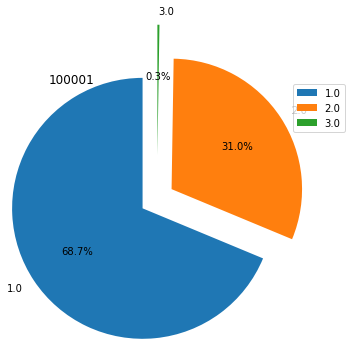

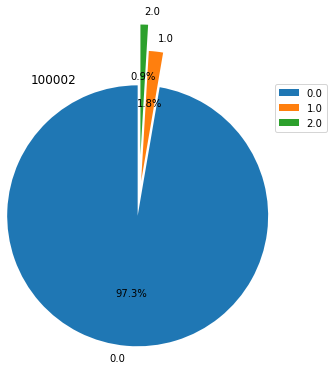

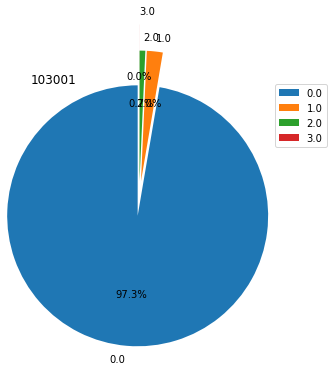

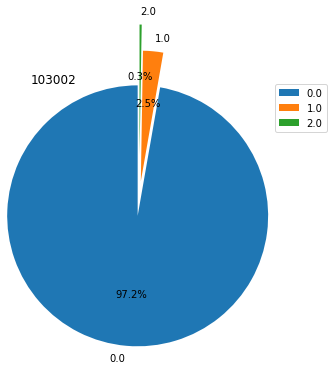

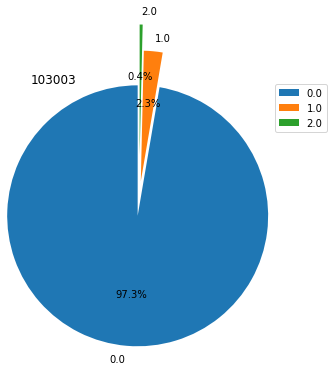

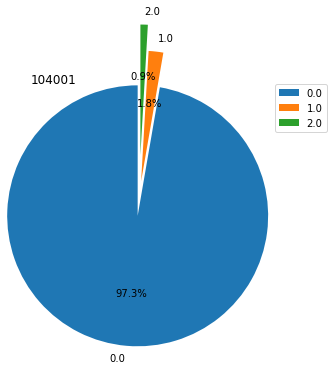

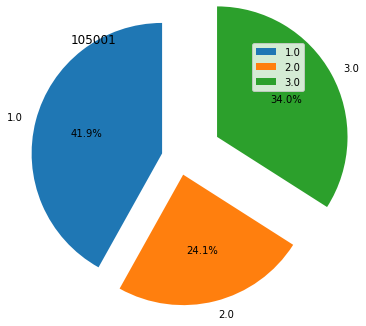

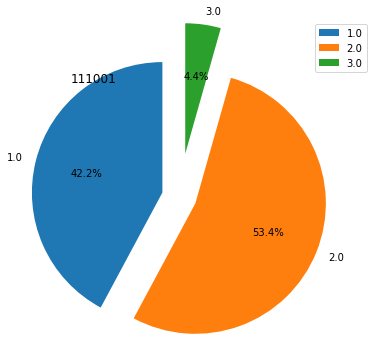

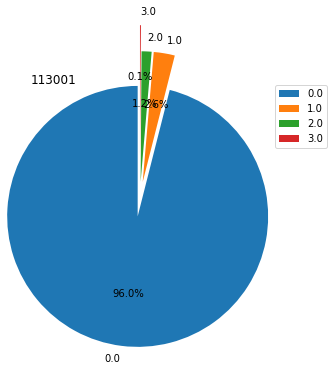

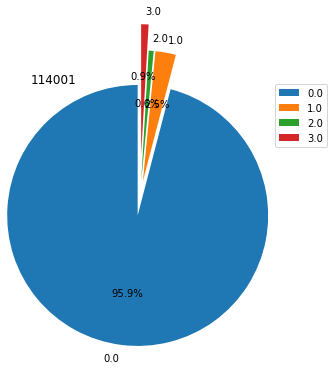

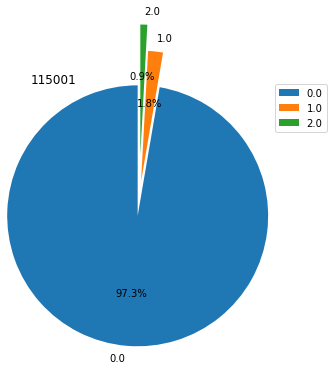

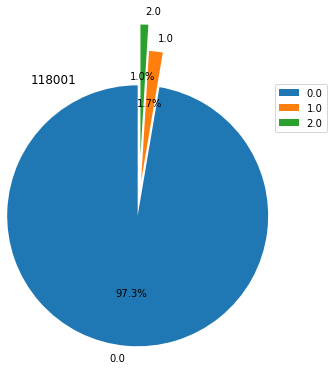

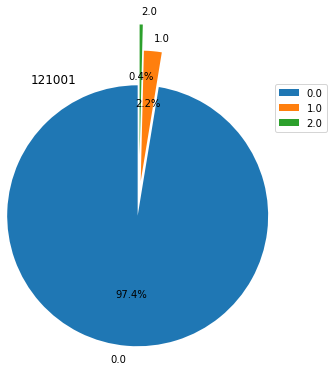

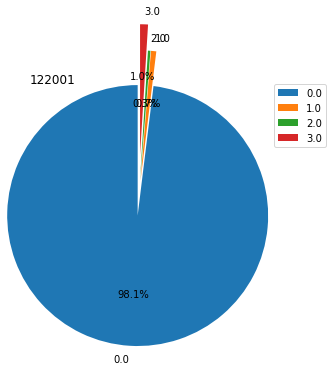

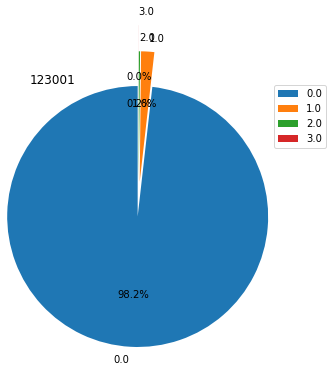

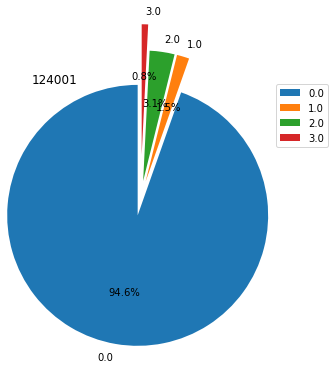

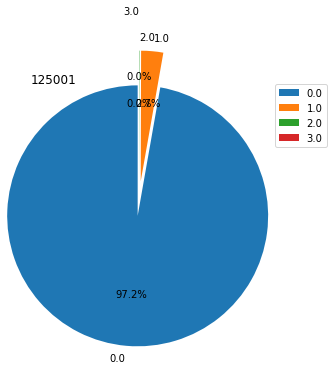

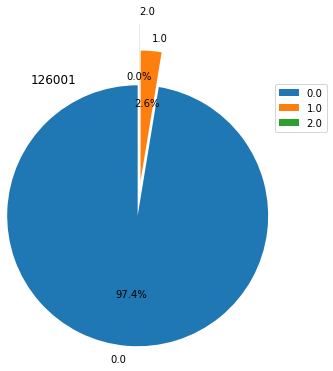

In [47]:
"""dataset['class_name'] = dataset['class'].apply(lambda x:
                                                     "Class 1: All significant waveforms" if int(x)==1 
                                                     else "Class 2: The noise level is increased" if int(x)==2
                                                     else "Class 3: The signal is unsuitable for any analysis. " if int(x)==3 
                                                     else "Class 0: The quality was not annotated ")
"""
for patient in dataannall.record.unique():
    pie_chart_data = dataset[dataset['record'] == patient].groupby('class')['sample'].sum()
    if pie_chart_data.shape[0] == 3:
        explode = (0.2,0.2,0.5)
    else:
        explode = (0.2,0.2,0.2,0.5)
    
    plt.figure()
    plt.pie(pie_chart_data.values, labels=pie_chart_data.index,  
           autopct='%1.1f%%',
           shadow=False, 
           startangle=90,
           explode=explode,
           radius=1.5
           )
    plt.title(patient, fontdict=None,loc='left')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [ ]:
# Do Pie Chart with plotly
#df = px.data.gapminder().query("year == 2007").query("continent == 'Europe'")
#df.loc[df['pop'] < 2.e6, 'country'] = 'Other countries' # Represent only large countries
#fig = px.pie(df, values='pop', names='country', title='Population of European continent')
#fig.show()

# Read source and create 2 lists
ecg_data : data
ecg_labels : labels quality class (1, 2 or 3; 0 means the quality was not annotated in this segment) 
Source : https://physionet.org/content/butqdb/1.0.0/

In [54]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
#For cut sample into n sample with cut_size
def ecgreshape(ecg_array,cut_size):
    ecg_size_multi = ceil(ecg_array.shape[0]/cut_size) # define number of subsamples
    ecg_result = np.zeros(ecg_size_multi*cut_size) # create an zero array of 5000 * subsamples
    ecg_result[:ecg_array.shape[0]] = ecg_array
    print(f"Array size {ecg_array.shape[0]} cut by {cut_size} done {ecg_size_multi}", end="\r")
    ecg_result = np.reshape(ecg_result, (ecg_size_multi,cut_size))
    return ecg_result

In [96]:
record.adc().reshape(-1,).shape

(3287,)

In [98]:
record.adc()[:5]

array([[-23653],
       [-23652],
       [-23650],
       [-23645],
       [-23647]])

In [99]:
record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[1]), sampto=int(dataannclear_nan_class.end[1]))
ecg_result_1 = ecgreshape(record.adc()[:,0],sample_size)
ecg_result_1

array([[-23653., -23652., -23650., ...,      0.,      0.,      0.]])

In [100]:
record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[1]), sampto=int(dataannclear_nan_class.end[1]))
ecg_result_1 = ecgreshape(record.adc()[:,0],sample_size)
ecg_result_1

array([[-23653., -23652., -23650., ...,      0.,      0.,      0.]])

In [101]:
record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[2]), sampto=int(dataannclear_nan_class.end[2]))
ecg_result_2 = ecgreshape(record.adc()[:,0],sample_size)
ecg_result_2

array([[-8633., -8621., -8608., ...,     0.,     0.,     0.]])

In [104]:
np.concatenate((ecg_result_1,ecg_result_2), axis=0)

array([[-23653., -23652., -23650., ...,      0.,      0.,      0.],
       [ -8633.,  -8621.,  -8608., ...,      0.,      0.,      0.]])

In [85]:
[1 for v in range(2)]

[1, 1]

In [124]:
a = [1,2]
a = a + [3,4]
a

[1, 2, 3, 4]

In [128]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['105001/105001_ECG']
ecg_data_test=[np.zeros(sample_size)]
ecg_labels_test=[0]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannclear_nan_class = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ] 
        for i in tqdm(dataannclear_nan_class[4:5].index):
            record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[i]), sampto=int(dataannclear_nan_class.end[i]))
            ecg_data_test = np.concatenate((ecg_data_test,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_size_multi = ceil(record.adc()[:,0].shape[0]/sample_size)
            ecg_labels_test = ecg_labels_test + [ int(dataannclear_nan_class["class"][i]) for ii in range(ecg_size_multi)]
            #ecg_labels_test.append([int(dataannclear_nan_class["class"][i])])
            

100%|██████████| 1/1 [00:00<00:00, 189.83it/s]

../aura-data/105001/105001_ECG


In [109]:
for i in dataannclear_nan_class[1:2].index: 
    print(i)

1


In [129]:
record.adc()[-5:]

array([[-52],
       [-40],
       [-19],
       [-22],
       [-46]])

In [131]:
ecg_data_test.shape

(9, 5000)

In [132]:
ecg_labels_test

[1, 1, 1, 1, 1, 1, 1, 1]

In [76]:
dataann = pd.read_csv("../aura-data/105001/105001_ANN.csv", names=header_list)
dataannclear_nan_class = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ]
display(dataannclear_nan_class[1:10].head())

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class
1,47323380.0,47388207.0,2.0,47323872.0,47329547.0,1.0,47323501,47323539,1,47323501.0,47326788.0,2.0
2,47388208.0,47404719.0,1.0,47329548.0,47333899.0,2.0,47323540,47326788,2,47326789.0,47329547.0,1.0
3,47404720.0,47449035.0,2.0,47333900.0,47370615.0,1.0,47326789,47329715,1,47329548.0,47333904.0,2.0
4,47449036.0,47492819.0,1.0,47370616.0,47377747.0,2.0,47329716,47333904,2,47333905.0,47370615.0,1.0
5,47492820.0,47530727.0,2.0,47377748.0,47405071.0,1.0,47333905,47370655,1,47370616.0,47377747.0,2.0


In [70]:
record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[0]), sampto=int(dataannclear_nan_class.end[0]))
record.adc()

array([[   -22],
       [   187],
       [   375],
       ...,
       [-23684],
       [-23678],
       [-23665]])

In [69]:
ecgreshape(record.adc()[:,0],sample_size)


array([[-2.200e+01,  1.870e+02,  3.750e+02, ...,  0.000e+00, -3.900e+01,
        -4.300e+01],
       [-3.100e+01, -1.900e+01, -1.200e+01, ...,  3.800e+01,  7.000e+00,
        -1.000e+00],
       [-2.000e+01, -2.400e+01,  0.000e+00, ...,  1.700e+01, -2.300e+01,
        -2.500e+01],
       ...,
       [ 7.000e+00,  1.500e+01,  1.200e+01, ..., -8.944e+03, -8.887e+03,
        -8.852e+03],
       [-8.888e+03, -8.902e+03, -8.883e+03, ..., -4.286e+03, -4.320e+03,
        -4.272e+03],
       [-4.198e+03, -4.127e+03, -4.169e+03, ...,  0.000e+00,  0.000e+00,
         0.000e+00]])

In [60]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['105001/105001_ECG']
ecg_data=[np.zeros(sample_size)]
ecg_labels=[]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannclear_nan_class = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ] 
        for i in tqdm(dataannclear_nan_class.index):
            record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[i]), sampto=int(dataannclear_nan_class.end[i]))
            ecg_data = np.concatenate((ecg_data,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_labels.append(int(dataannclear_nan_class["class"][i]))
            

  0%|          | 0/1354 [00:00<?, ?it/s]

../aura-data/105001/105001_ECG


  0%|          | 1/1354 [00:03<1:12:00,  3.19s/it]

  0%|          | 2/1354 [00:03<52:53,  2.35s/it]  

  0%|          | 3/1354 [00:03<39:05,  1.74s/it]

  0%|          | 4/1354 [00:04<31:13,  1.39s/it]

  0%|          | 5/1354 [00:04<23:56,  1.07s/it]

  0%|          | 6/1354 [00:05<20:29,  1.10it/s]

  1%|          | 7/1354 [00:05<16:46,  1.34it/s]

  1%|          | 8/1354 [00:06<14:18,  1.57it/s]

  1%|          | 9/1354 [00:06<13:37,  1.65it/s]

  1%|          | 10/1354 [00:07<12:19,  1.82it/s]

  1%|          | 11/1354 [00:07<10:32,  2.12it/s]

  1%|          | 12/1354 [00:07<09:33,  2.34it/s]

  1%|          | 13/1354 [00:07<08:34,  2.61it/s]

  1%|          | 14/1354 [00:08<08:30,  2.63it/s]

  1%|          | 15/1354 [00:08<09:17,  2.40it/s]

  1%|          | 16/1354 [00:09<08:53,  2.51it/s]

  1%|▏         | 17/1354 [00:09<08:21,  2.66it/s]

  1%|▏         | 18/1354 [00:09<08:31,  2.61it/s]

  1%|▏         | 19/1354 [00:10<08:04,  2.76it/s]

  1%|▏         | 20/1354 [00:10<07:39,  2.91it/s]

  2%|▏         | 21/1354 [00:10<07:18,  3.04it/s]

  2%|▏         | 22/1354 [00:11<07:01,  3.16it/s]

  2%|▏         | 23/1354 [00:11<07:28,  2.97it/s]

  2%|▏         | 24/1354 [00:11<07:19,  3.02it/s]

  2%|▏         | 25/1354 [00:12<07:31,  2.94it/s]

  2%|▏         | 26/1354 [00:12<07:41,  2.88it/s]

  2%|▏         | 27/1354 [00:12<07:23,  2.99it/s]

  2%|▏         | 28/1354 [00:13<07:35,  2.91it/s]

  2%|▏         | 29/1354 [00:13<07:23,  2.99it/s]

  2%|▏         | 30/1354 [00:13<07:33,  2.92it/s]

  2%|▏         | 31/1354 [00:14<07:16,  3.03it/s]

  2%|▏         | 32/1354 [00:14<06:57,  3.16it/s]

  2%|▏         | 33/1354 [00:14<06:46,  3.25it/s]

  3%|▎         | 34/1354 [00:15<07:02,  3.12it/s]

  3%|▎         | 35/1354 [00:15<07:35,  2.90it/s]

  3%|▎         | 36/1354 [00:15<08:12,  2.68it/s]

  3%|▎         | 37/1354 [00:16<08:15,  2.66it/s]

  3%|▎         | 38/1354 [00:16<08:01,  2.73it/s]

  3%|▎         | 39/1354 [00:17<08:07,  2.69it/s]

  3%|▎         | 40/1354 [00:17<08:30,  2.57it/s]

  3%|▎         | 41/1354 [00:17<08:16,  2.65it/s]

  3%|▎         | 42/1354 [00:18<07:54,  2.77it/s]

  3%|▎         | 43/1354 [00:18<08:28,  2.58it/s]

  3%|▎         | 44/1354 [00:18<08:19,  2.62it/s]

  3%|▎         | 45/1354 [00:19<08:50,  2.47it/s]

  3%|▎         | 46/1354 [00:19<08:45,  2.49it/s]

  3%|▎         | 47/1354 [00:20<08:08,  2.68it/s]

  4%|▎         | 48/1354 [00:20<07:36,  2.86it/s]

  4%|▎         | 49/1354 [00:20<07:34,  2.87it/s]

  4%|▎         | 50/1354 [00:21<08:21,  2.60it/s]

  4%|▍         | 51/1354 [00:21<07:54,  2.75it/s]

  4%|▍         | 52/1354 [00:21<08:13,  2.64it/s]

  4%|▍         | 53/1354 [00:22<09:12,  2.35it/s]

  4%|▍         | 54/1354 [00:22<08:39,  2.50it/s]

  4%|▍         | 55/1354 [00:23<09:01,  2.40it/s]

  4%|▍         | 56/1354 [00:23<08:44,  2.47it/s]

  4%|▍         | 57/1354 [00:24<08:45,  2.47it/s]

  4%|▍         | 58/1354 [00:24<08:08,  2.65it/s]

  4%|▍         | 59/1354 [00:24<07:54,  2.73it/s]

  4%|▍         | 60/1354 [00:25<07:54,  2.73it/s]

  5%|▍         | 61/1354 [00:25<07:43,  2.79it/s]

  5%|▍         | 62/1354 [00:25<07:33,  2.85it/s]

  5%|▍         | 63/1354 [00:26<07:35,  2.84it/s]

  5%|▍         | 64/1354 [00:26<07:36,  2.82it/s]

  5%|▍         | 65/1354 [00:26<07:44,  2.78it/s]

  5%|▍         | 66/1354 [00:27<07:39,  2.80it/s]

  5%|▍         | 67/1354 [00:27<07:38,  2.81it/s]

  5%|▌         | 68/1354 [00:27<07:34,  2.83it/s]

  5%|▌         | 69/1354 [00:28<07:52,  2.72it/s]

  5%|▌         | 70/1354 [00:28<07:39,  2.79it/s]

  5%|▌         | 71/1354 [00:29<07:55,  2.70it/s]

  5%|▌         | 72/1354 [00:29<08:06,  2.63it/s]

  5%|▌         | 73/1354 [00:29<07:56,  2.69it/s]

  5%|▌         | 74/1354 [00:30<07:39,  2.79it/s]

  6%|▌         | 75/1354 [00:30<07:16,  2.93it/s]

  6%|▌         | 76/1354 [00:30<07:00,  3.04it/s]

  6%|▌         | 77/1354 [00:31<07:35,  2.80it/s]

  6%|▌         | 78/1354 [00:31<08:20,  2.55it/s]

  6%|▌         | 79/1354 [00:31<07:54,  2.68it/s]

  6%|▌         | 80/1354 [00:32<07:53,  2.69it/s]

  6%|▌         | 81/1354 [00:32<07:57,  2.67it/s]

  6%|▌         | 82/1354 [00:32<07:36,  2.79it/s]

  6%|▌         | 83/1354 [00:33<07:17,  2.90it/s]

  6%|▌         | 84/1354 [00:33<07:22,  2.87it/s]

  6%|▋         | 85/1354 [00:33<07:03,  3.00it/s]

  6%|▋         | 86/1354 [00:34<06:54,  3.06it/s]

  6%|▋         | 87/1354 [00:34<06:41,  3.15it/s]

  6%|▋         | 88/1354 [00:34<06:36,  3.19it/s]

  7%|▋         | 89/1354 [00:35<06:42,  3.14it/s]

  7%|▋         | 90/1354 [00:35<06:37,  3.18it/s]

  7%|▋         | 91/1354 [00:35<06:34,  3.20it/s]

  7%|▋         | 92/1354 [00:36<06:32,  3.21it/s]

  7%|▋         | 93/1354 [00:36<06:30,  3.23it/s]

  7%|▋         | 94/1354 [00:36<06:35,  3.18it/s]

  7%|▋         | 95/1354 [00:37<06:51,  3.06it/s]

  7%|▋         | 96/1354 [00:37<06:47,  3.09it/s]

  7%|▋         | 97/1354 [00:37<06:46,  3.09it/s]

  7%|▋         | 98/1354 [00:38<07:51,  2.66it/s]

  7%|▋         | 99/1354 [00:38<08:03,  2.59it/s]

  7%|▋         | 100/1354 [00:38<07:37,  2.74it/s]

  7%|▋         | 101/1354 [00:39<07:13,  2.89it/s]

  8%|▊         | 102/1354 [00:39<06:59,  2.98it/s]

  8%|▊         | 103/1354 [00:39<06:53,  3.02it/s]

  8%|▊         | 104/1354 [00:40<06:53,  3.02it/s]

  8%|▊         | 105/1354 [00:40<06:49,  3.05it/s]

  8%|▊         | 106/1354 [00:40<06:52,  3.03it/s]

  8%|▊         | 107/1354 [00:41<07:01,  2.96it/s]

  8%|▊         | 108/1354 [00:41<07:25,  2.80it/s]

  8%|▊         | 109/1354 [00:42<07:59,  2.60it/s]

  8%|▊         | 110/1354 [00:42<07:54,  2.62it/s]

  8%|▊         | 111/1354 [00:42<07:59,  2.59it/s]

  8%|▊         | 112/1354 [00:43<08:20,  2.48it/s]

  8%|▊         | 113/1354 [00:43<08:09,  2.53it/s]

  8%|▊         | 114/1354 [00:44<07:55,  2.61it/s]

  8%|▊         | 115/1354 [00:44<08:24,  2.45it/s]

  9%|▊         | 116/1354 [00:44<07:59,  2.58it/s]

  9%|▊         | 117/1354 [00:45<08:12,  2.51it/s]

  9%|▊         | 118/1354 [00:45<08:19,  2.48it/s]

  9%|▉         | 119/1354 [00:46<07:59,  2.58it/s]

  9%|▉         | 120/1354 [00:46<08:09,  2.52it/s]

  9%|▉         | 121/1354 [00:46<07:49,  2.63it/s]

  9%|▉         | 122/1354 [00:47<07:57,  2.58it/s]

  9%|▉         | 123/1354 [00:47<08:02,  2.55it/s]

  9%|▉         | 124/1354 [00:47<07:51,  2.61it/s]

  9%|▉         | 125/1354 [00:48<07:43,  2.65it/s]

  9%|▉         | 126/1354 [00:48<07:55,  2.58it/s]

  9%|▉         | 127/1354 [00:49<07:31,  2.72it/s]

  9%|▉         | 128/1354 [00:49<07:14,  2.82it/s]

 10%|▉         | 129/1354 [00:49<07:00,  2.91it/s]

 10%|▉         | 130/1354 [00:50<06:51,  2.97it/s]

 10%|▉         | 131/1354 [00:50<06:48,  3.00it/s]

 10%|▉         | 132/1354 [00:50<06:39,  3.06it/s]

 10%|▉         | 133/1354 [00:50<06:40,  3.05it/s]

 10%|▉         | 134/1354 [00:51<06:37,  3.07it/s]

 10%|▉         | 135/1354 [00:51<06:37,  3.07it/s]

 10%|█         | 136/1354 [00:51<06:35,  3.08it/s]

 10%|█         | 137/1354 [00:52<06:37,  3.07it/s]

 10%|█         | 138/1354 [00:52<06:31,  3.10it/s]

 10%|█         | 139/1354 [00:52<06:29,  3.12it/s]

 10%|█         | 140/1354 [00:53<06:37,  3.05it/s]

 10%|█         | 141/1354 [00:53<06:36,  3.06it/s]

 10%|█         | 142/1354 [00:54<07:10,  2.82it/s]

 11%|█         | 143/1354 [00:54<07:12,  2.80it/s]

 11%|█         | 144/1354 [00:54<08:24,  2.40it/s]

 11%|█         | 145/1354 [00:55<08:40,  2.32it/s]

 11%|█         | 146/1354 [00:55<08:26,  2.39it/s]

 11%|█         | 147/1354 [00:56<08:20,  2.41it/s]

 11%|█         | 148/1354 [00:56<08:24,  2.39it/s]

 11%|█         | 149/1354 [00:57<10:03,  2.00it/s]

 11%|█         | 150/1354 [00:58<12:05,  1.66it/s]

 11%|█         | 151/1354 [00:58<13:12,  1.52it/s]

 11%|█         | 152/1354 [00:59<11:31,  1.74it/s]

 11%|█▏        | 153/1354 [00:59<10:14,  1.95it/s]

 11%|█▏        | 154/1354 [01:00<09:17,  2.15it/s]

 11%|█▏        | 155/1354 [01:00<09:02,  2.21it/s]

 12%|█▏        | 156/1354 [01:00<09:25,  2.12it/s]

 12%|█▏        | 157/1354 [01:01<09:36,  2.08it/s]

 12%|█▏        | 158/1354 [01:01<09:06,  2.19it/s]

 12%|█▏        | 159/1354 [01:02<09:06,  2.19it/s]

 12%|█▏        | 160/1354 [01:02<08:39,  2.30it/s]

 12%|█▏        | 161/1354 [01:03<08:40,  2.29it/s]

 12%|█▏        | 162/1354 [01:03<08:16,  2.40it/s]

 12%|█▏        | 163/1354 [01:03<08:03,  2.46it/s]

 12%|█▏        | 164/1354 [01:04<09:33,  2.08it/s]

 12%|█▏        | 165/1354 [01:04<08:44,  2.27it/s]

 12%|█▏        | 166/1354 [01:05<08:24,  2.35it/s]

 12%|█▏        | 167/1354 [01:05<08:21,  2.37it/s]

 12%|█▏        | 168/1354 [01:06<09:09,  2.16it/s]

 12%|█▏        | 169/1354 [01:06<08:38,  2.29it/s]

 13%|█▎        | 170/1354 [01:07<08:24,  2.35it/s]

 13%|█▎        | 171/1354 [01:07<08:53,  2.22it/s]

 13%|█▎        | 172/1354 [01:08<09:39,  2.04it/s]

 13%|█▎        | 173/1354 [01:08<09:00,  2.19it/s]

 13%|█▎        | 174/1354 [01:08<08:26,  2.33it/s]

 13%|█▎        | 175/1354 [01:09<08:30,  2.31it/s]

 13%|█▎        | 176/1354 [01:09<07:55,  2.48it/s]

 13%|█▎        | 177/1354 [01:09<07:28,  2.63it/s]

 13%|█▎        | 178/1354 [01:10<07:18,  2.68it/s]

 13%|█▎        | 179/1354 [01:10<07:26,  2.63it/s]

 13%|█▎        | 180/1354 [01:11<08:06,  2.42it/s]

 13%|█▎        | 181/1354 [01:11<08:39,  2.26it/s]

 13%|█▎        | 182/1354 [01:12<09:14,  2.12it/s]

 14%|█▎        | 183/1354 [01:12<08:30,  2.29it/s]

 14%|█▎        | 184/1354 [01:13<09:01,  2.16it/s]

 14%|█▎        | 185/1354 [01:13<09:17,  2.10it/s]

 14%|█▎        | 186/1354 [01:14<09:36,  2.03it/s]

 14%|█▍        | 187/1354 [01:14<09:13,  2.11it/s]

 14%|█▍        | 188/1354 [01:14<08:29,  2.29it/s]

 14%|█▍        | 189/1354 [01:15<08:17,  2.34it/s]

 14%|█▍        | 190/1354 [01:15<07:46,  2.49it/s]

 14%|█▍        | 191/1354 [01:16<07:26,  2.61it/s]

 14%|█▍        | 192/1354 [01:16<07:49,  2.48it/s]

 14%|█▍        | 193/1354 [01:16<07:40,  2.52it/s]

 14%|█▍        | 194/1354 [01:17<07:31,  2.57it/s]

 14%|█▍        | 195/1354 [01:17<07:32,  2.56it/s]

 14%|█▍        | 196/1354 [01:18<07:27,  2.59it/s]

 15%|█▍        | 197/1354 [01:18<07:10,  2.68it/s]

 15%|█▍        | 198/1354 [01:18<07:14,  2.66it/s]

 15%|█▍        | 199/1354 [01:19<08:35,  2.24it/s]

 15%|█▍        | 200/1354 [01:19<08:38,  2.22it/s]

 15%|█▍        | 201/1354 [01:20<08:06,  2.37it/s]

 15%|█▍        | 202/1354 [01:20<07:34,  2.54it/s]

 15%|█▍        | 203/1354 [01:20<07:22,  2.60it/s]

 15%|█▌        | 204/1354 [01:21<07:10,  2.67it/s]

 15%|█▌        | 205/1354 [01:21<07:04,  2.71it/s]

 15%|█▌        | 206/1354 [01:21<06:54,  2.77it/s]

 15%|█▌        | 207/1354 [01:22<07:01,  2.72it/s]

 15%|█▌        | 208/1354 [01:22<07:35,  2.52it/s]

 15%|█▌        | 209/1354 [01:23<08:21,  2.28it/s]

 16%|█▌        | 210/1354 [01:23<07:58,  2.39it/s]

 16%|█▌        | 211/1354 [01:24<07:36,  2.50it/s]

 16%|█▌        | 212/1354 [01:24<07:21,  2.59it/s]

 16%|█▌        | 213/1354 [01:24<07:08,  2.66it/s]

 16%|█▌        | 214/1354 [01:25<07:05,  2.68it/s]

 16%|█▌        | 215/1354 [01:25<07:14,  2.62it/s]

 16%|█▌        | 216/1354 [01:26<08:08,  2.33it/s]

 16%|█▌        | 217/1354 [01:26<07:42,  2.46it/s]

 16%|█▌        | 218/1354 [01:26<07:37,  2.48it/s]

 16%|█▌        | 219/1354 [01:27<07:18,  2.59it/s]

 16%|█▌        | 220/1354 [01:27<07:02,  2.68it/s]

 16%|█▋        | 221/1354 [01:27<06:53,  2.74it/s]

 16%|█▋        | 222/1354 [01:28<06:55,  2.73it/s]

 16%|█▋        | 223/1354 [01:28<06:50,  2.76it/s]

 17%|█▋        | 224/1354 [01:28<06:43,  2.80it/s]

 17%|█▋        | 225/1354 [01:29<06:41,  2.81it/s]

 17%|█▋        | 226/1354 [01:29<06:34,  2.86it/s]

 17%|█▋        | 227/1354 [01:29<06:41,  2.81it/s]

 17%|█▋        | 228/1354 [01:30<06:42,  2.80it/s]

 17%|█▋        | 229/1354 [01:30<06:39,  2.82it/s]

 17%|█▋        | 230/1354 [01:31<06:41,  2.80it/s]

 17%|█▋        | 231/1354 [01:31<06:39,  2.81it/s]

 17%|█▋        | 232/1354 [01:31<06:36,  2.83it/s]

 17%|█▋        | 233/1354 [01:32<06:44,  2.77it/s]

 17%|█▋        | 234/1354 [01:32<06:37,  2.82it/s]

 17%|█▋        | 235/1354 [01:32<06:30,  2.87it/s]

 17%|█▋        | 236/1354 [01:33<06:36,  2.82it/s]

 18%|█▊        | 237/1354 [01:33<06:46,  2.75it/s]

 18%|█▊        | 238/1354 [01:33<06:39,  2.80it/s]

 18%|█▊        | 239/1354 [01:34<06:37,  2.81it/s]

 18%|█▊        | 240/1354 [01:34<06:40,  2.78it/s]

 18%|█▊        | 241/1354 [01:35<07:29,  2.48it/s]

 18%|█▊        | 242/1354 [01:35<07:24,  2.50it/s]

 18%|█▊        | 243/1354 [01:35<07:17,  2.54it/s]

 18%|█▊        | 244/1354 [01:36<07:57,  2.33it/s]

 18%|█▊        | 245/1354 [01:36<07:42,  2.40it/s]

 18%|█▊        | 246/1354 [01:37<07:24,  2.49it/s]

 18%|█▊        | 247/1354 [01:37<07:09,  2.58it/s]

 18%|█▊        | 248/1354 [01:37<06:59,  2.64it/s]

 18%|█▊        | 249/1354 [01:38<06:52,  2.68it/s]

 18%|█▊        | 250/1354 [01:38<06:59,  2.63it/s]

 19%|█▊        | 251/1354 [01:39<06:56,  2.65it/s]

 19%|█▊        | 252/1354 [01:39<06:57,  2.64it/s]

 19%|█▊        | 253/1354 [01:39<06:51,  2.68it/s]

 19%|█▉        | 254/1354 [01:40<06:53,  2.66it/s]

 19%|█▉        | 255/1354 [01:41<13:34,  1.35it/s]

 19%|█▉        | 256/1354 [01:42<14:09,  1.29it/s]

 19%|█▉        | 257/1354 [01:42<12:05,  1.51it/s]

 19%|█▉        | 258/1354 [01:43<10:48,  1.69it/s]

 19%|█▉        | 259/1354 [01:43<09:26,  1.93it/s]

 19%|█▉        | 260/1354 [01:44<08:37,  2.11it/s]

 19%|█▉        | 261/1354 [01:44<07:49,  2.33it/s]

 19%|█▉        | 262/1354 [01:44<07:17,  2.50it/s]

 19%|█▉        | 263/1354 [01:45<07:01,  2.59it/s]

 19%|█▉        | 264/1354 [01:45<06:52,  2.64it/s]

 20%|█▉        | 265/1354 [01:45<06:56,  2.62it/s]

 20%|█▉        | 266/1354 [01:46<07:09,  2.53it/s]

 20%|█▉        | 267/1354 [01:46<07:34,  2.39it/s]

 20%|█▉        | 268/1354 [01:47<07:18,  2.48it/s]

 20%|█▉        | 269/1354 [01:47<07:24,  2.44it/s]

 20%|█▉        | 270/1354 [01:48<07:31,  2.40it/s]

 20%|██        | 271/1354 [01:48<07:21,  2.45it/s]

 20%|██        | 272/1354 [01:48<07:12,  2.50it/s]

 20%|██        | 273/1354 [01:49<07:02,  2.56it/s]

 20%|██        | 274/1354 [01:49<07:02,  2.55it/s]

 20%|██        | 275/1354 [01:49<07:02,  2.56it/s]

 20%|██        | 276/1354 [01:50<06:49,  2.64it/s]

 20%|██        | 277/1354 [01:50<06:37,  2.71it/s]

 21%|██        | 278/1354 [01:51<06:43,  2.67it/s]

 21%|██        | 279/1354 [01:51<06:32,  2.74it/s]

 21%|██        | 280/1354 [01:51<06:27,  2.77it/s]

 21%|██        | 281/1354 [01:52<06:23,  2.80it/s]

 21%|██        | 282/1354 [01:52<06:14,  2.86it/s]

 21%|██        | 283/1354 [01:52<06:11,  2.89it/s]

 21%|██        | 284/1354 [01:53<06:22,  2.80it/s]

 21%|██        | 285/1354 [01:53<06:53,  2.59it/s]

 21%|██        | 286/1354 [01:53<06:56,  2.57it/s]

 21%|██        | 287/1354 [01:54<07:06,  2.50it/s]

 21%|██▏       | 288/1354 [01:54<07:19,  2.42it/s]

 21%|██▏       | 289/1354 [01:55<07:23,  2.40it/s]

 21%|██▏       | 290/1354 [01:55<07:04,  2.51it/s]

 21%|██▏       | 291/1354 [01:56<07:09,  2.47it/s]

 22%|██▏       | 292/1354 [01:56<07:27,  2.37it/s]

 22%|██▏       | 293/1354 [01:56<07:18,  2.42it/s]

 22%|██▏       | 294/1354 [01:57<07:06,  2.48it/s]

 22%|██▏       | 295/1354 [01:57<06:45,  2.61it/s]

 22%|██▏       | 296/1354 [01:57<06:37,  2.66it/s]

 22%|██▏       | 297/1354 [01:58<06:31,  2.70it/s]

 22%|██▏       | 298/1354 [01:58<06:21,  2.77it/s]

 22%|██▏       | 299/1354 [01:59<07:13,  2.44it/s]

 22%|██▏       | 300/1354 [01:59<06:53,  2.55it/s]

 22%|██▏       | 301/1354 [01:59<06:41,  2.62it/s]

 22%|██▏       | 302/1354 [02:00<06:30,  2.69it/s]

 22%|██▏       | 303/1354 [02:00<06:25,  2.72it/s]

 22%|██▏       | 304/1354 [02:00<06:29,  2.70it/s]

 23%|██▎       | 305/1354 [02:01<06:42,  2.61it/s]

 23%|██▎       | 306/1354 [02:01<06:33,  2.66it/s]

 23%|██▎       | 307/1354 [02:02<06:30,  2.68it/s]

 23%|██▎       | 308/1354 [02:02<06:26,  2.71it/s]

 23%|██▎       | 309/1354 [02:02<06:21,  2.74it/s]

 23%|██▎       | 310/1354 [02:03<06:21,  2.74it/s]

 23%|██▎       | 311/1354 [02:03<06:14,  2.79it/s]

 23%|██▎       | 312/1354 [02:03<06:16,  2.76it/s]

 23%|██▎       | 313/1354 [02:04<06:15,  2.77it/s]

 23%|██▎       | 314/1354 [02:04<06:19,  2.74it/s]

 23%|██▎       | 315/1354 [02:05<06:22,  2.71it/s]

 23%|██▎       | 316/1354 [02:05<06:20,  2.73it/s]

 23%|██▎       | 317/1354 [02:05<06:19,  2.73it/s]

 23%|██▎       | 318/1354 [02:06<07:06,  2.43it/s]

 24%|██▎       | 319/1354 [02:06<07:05,  2.43it/s]

 24%|██▎       | 320/1354 [02:07<07:02,  2.45it/s]

 24%|██▎       | 321/1354 [02:07<06:53,  2.50it/s]

 24%|██▍       | 322/1354 [02:07<06:40,  2.58it/s]

 24%|██▍       | 323/1354 [02:08<06:31,  2.63it/s]

 24%|██▍       | 324/1354 [02:08<06:23,  2.69it/s]

 24%|██▍       | 325/1354 [02:08<06:20,  2.71it/s]

 24%|██▍       | 326/1354 [02:09<06:34,  2.60it/s]

 24%|██▍       | 327/1354 [02:09<06:35,  2.60it/s]

 24%|██▍       | 328/1354 [02:10<06:33,  2.61it/s]

 24%|██▍       | 329/1354 [02:10<06:32,  2.61it/s]

 24%|██▍       | 330/1354 [02:10<06:31,  2.61it/s]

 24%|██▍       | 331/1354 [02:11<06:29,  2.63it/s]

 25%|██▍       | 332/1354 [02:11<06:42,  2.54it/s]

 25%|██▍       | 333/1354 [02:12<07:20,  2.32it/s]

 25%|██▍       | 334/1354 [02:12<07:07,  2.39it/s]

 25%|██▍       | 335/1354 [02:12<06:55,  2.45it/s]

 25%|██▍       | 336/1354 [02:13<07:00,  2.42it/s]

 25%|██▍       | 337/1354 [02:13<07:04,  2.39it/s]

 25%|██▍       | 338/1354 [02:14<07:24,  2.28it/s]

 25%|██▌       | 339/1354 [02:14<07:20,  2.30it/s]

 25%|██▌       | 340/1354 [02:15<07:22,  2.29it/s]

 25%|██▌       | 341/1354 [02:15<07:19,  2.31it/s]

 25%|██▌       | 342/1354 [02:15<07:16,  2.32it/s]

 25%|██▌       | 343/1354 [02:16<07:10,  2.35it/s]

 25%|██▌       | 344/1354 [02:16<07:08,  2.36it/s]

 25%|██▌       | 345/1354 [02:17<07:17,  2.30it/s]

 26%|██▌       | 346/1354 [02:17<07:12,  2.33it/s]

 26%|██▌       | 347/1354 [02:18<07:19,  2.29it/s]

 26%|██▌       | 348/1354 [02:18<08:06,  2.07it/s]

 26%|██▌       | 349/1354 [02:19<07:51,  2.13it/s]

 26%|██▌       | 350/1354 [02:19<07:47,  2.15it/s]

 26%|██▌       | 351/1354 [02:20<07:47,  2.15it/s]

 26%|██▌       | 352/1354 [02:20<07:40,  2.17it/s]

 26%|██▌       | 353/1354 [02:20<07:38,  2.18it/s]

 26%|██▌       | 354/1354 [02:21<07:39,  2.17it/s]

 26%|██▌       | 355/1354 [02:21<07:32,  2.21it/s]

 26%|██▋       | 356/1354 [02:22<07:42,  2.16it/s]

 26%|██▋       | 357/1354 [02:23<09:25,  1.76it/s]

 26%|██▋       | 358/1354 [02:23<09:05,  1.83it/s]

 27%|██▋       | 359/1354 [02:25<14:40,  1.13it/s]

 27%|██▋       | 360/1354 [02:26<14:21,  1.15it/s]

 27%|██▋       | 361/1354 [02:26<13:38,  1.21it/s]

 27%|██▋       | 362/1354 [02:27<13:04,  1.26it/s]

 27%|██▋       | 363/1354 [02:28<12:42,  1.30it/s]

 27%|██▋       | 364/1354 [02:29<13:23,  1.23it/s]

 27%|██▋       | 365/1354 [02:29<12:19,  1.34it/s]

 27%|██▋       | 366/1354 [02:30<11:20,  1.45it/s]

 27%|██▋       | 367/1354 [02:31<11:22,  1.45it/s]

 27%|██▋       | 368/1354 [02:31<10:32,  1.56it/s]

 27%|██▋       | 369/1354 [02:32<10:18,  1.59it/s]

 27%|██▋       | 370/1354 [02:32<10:30,  1.56it/s]

 27%|██▋       | 371/1354 [02:34<14:31,  1.13it/s]

 27%|██▋       | 372/1354 [02:36<18:23,  1.12s/it]

 28%|██▊       | 373/1354 [02:36<16:41,  1.02s/it]

 28%|██▊       | 374/1354 [02:38<18:11,  1.11s/it]

 28%|██▊       | 375/1354 [02:39<16:57,  1.04s/it]

 28%|██▊       | 376/1354 [02:39<15:21,  1.06it/s]

 28%|██▊       | 377/1354 [02:40<14:05,  1.16it/s]

 28%|██▊       | 378/1354 [02:41<13:40,  1.19it/s]

 28%|██▊       | 379/1354 [02:41<12:12,  1.33it/s]

 28%|██▊       | 380/1354 [02:42<11:19,  1.43it/s]

 28%|██▊       | 381/1354 [02:43<12:07,  1.34it/s]

 28%|██▊       | 382/1354 [02:43<11:09,  1.45it/s]

 28%|██▊       | 383/1354 [02:44<10:01,  1.61it/s]

 28%|██▊       | 384/1354 [02:44<09:24,  1.72it/s]

 28%|██▊       | 385/1354 [02:45<11:27,  1.41it/s]

 29%|██▊       | 386/1354 [02:46<12:13,  1.32it/s]

 29%|██▊       | 387/1354 [02:47<11:17,  1.43it/s]

 29%|██▊       | 388/1354 [02:47<10:26,  1.54it/s]

 29%|██▊       | 389/1354 [02:48<09:35,  1.68it/s]

 29%|██▉       | 390/1354 [02:48<08:59,  1.79it/s]

 29%|██▉       | 391/1354 [02:49<08:38,  1.86it/s]

 29%|██▉       | 392/1354 [02:49<08:11,  1.96it/s]

 29%|██▉       | 393/1354 [02:50<08:23,  1.91it/s]

 29%|██▉       | 394/1354 [02:51<11:11,  1.43it/s]

 29%|██▉       | 395/1354 [02:52<14:18,  1.12it/s]

 29%|██▉       | 396/1354 [02:53<13:54,  1.15it/s]

 29%|██▉       | 397/1354 [02:54<15:38,  1.02it/s]

 29%|██▉       | 398/1354 [02:55<16:29,  1.03s/it]

 29%|██▉       | 399/1354 [02:57<19:27,  1.22s/it]

 30%|██▉       | 400/1354 [02:59<23:15,  1.46s/it]

 30%|██▉       | 401/1354 [03:00<18:59,  1.20s/it]

 30%|██▉       | 402/1354 [03:00<16:29,  1.04s/it]

 30%|██▉       | 403/1354 [03:01<14:06,  1.12it/s]

 30%|██▉       | 404/1354 [03:01<11:58,  1.32it/s]

 30%|██▉       | 405/1354 [03:02<11:23,  1.39it/s]

 30%|██▉       | 406/1354 [03:03<11:37,  1.36it/s]

 30%|███       | 407/1354 [03:03<11:09,  1.41it/s]

 30%|███       | 408/1354 [03:04<11:08,  1.41it/s]

 30%|███       | 409/1354 [03:05<12:54,  1.22it/s]

 30%|███       | 410/1354 [03:06<11:59,  1.31it/s]

 30%|███       | 411/1354 [03:06<11:12,  1.40it/s]

 30%|███       | 412/1354 [03:07<10:37,  1.48it/s]

 31%|███       | 413/1354 [03:08<11:08,  1.41it/s]

 31%|███       | 414/1354 [03:08<10:36,  1.48it/s]

 31%|███       | 415/1354 [03:09<11:05,  1.41it/s]

 31%|███       | 416/1354 [03:10<10:08,  1.54it/s]

 31%|███       | 417/1354 [03:10<09:27,  1.65it/s]

 31%|███       | 418/1354 [03:11<09:15,  1.68it/s]

 31%|███       | 419/1354 [03:11<08:59,  1.73it/s]

 31%|███       | 420/1354 [03:12<08:33,  1.82it/s]

 31%|███       | 421/1354 [03:12<08:43,  1.78it/s]

 31%|███       | 422/1354 [03:13<08:46,  1.77it/s]

 31%|███       | 423/1354 [03:13<09:20,  1.66it/s]

 31%|███▏      | 424/1354 [03:14<09:13,  1.68it/s]

 31%|███▏      | 425/1354 [03:15<09:10,  1.69it/s]

 31%|███▏      | 426/1354 [03:16<11:02,  1.40it/s]

 32%|███▏      | 427/1354 [03:16<10:33,  1.46it/s]

 32%|███▏      | 428/1354 [03:17<11:38,  1.33it/s]

 32%|███▏      | 429/1354 [03:18<11:50,  1.30it/s]

 32%|███▏      | 430/1354 [03:19<11:44,  1.31it/s]

 32%|███▏      | 431/1354 [03:19<11:05,  1.39it/s]

 32%|███▏      | 432/1354 [03:20<10:53,  1.41it/s]

 32%|███▏      | 433/1354 [03:21<10:16,  1.49it/s]

 32%|███▏      | 434/1354 [03:21<09:50,  1.56it/s]

 32%|███▏      | 435/1354 [03:22<09:17,  1.65it/s]

 32%|███▏      | 436/1354 [03:22<08:44,  1.75it/s]

 32%|███▏      | 437/1354 [03:23<08:23,  1.82it/s]

 32%|███▏      | 438/1354 [03:23<08:01,  1.90it/s]

 32%|███▏      | 439/1354 [03:24<07:48,  1.95it/s]

 32%|███▏      | 440/1354 [03:24<07:33,  2.01it/s]

 33%|███▎      | 441/1354 [03:25<08:02,  1.89it/s]

 33%|███▎      | 442/1354 [03:25<08:03,  1.89it/s]

 33%|███▎      | 443/1354 [03:26<08:07,  1.87it/s]

 33%|███▎      | 444/1354 [03:26<08:15,  1.84it/s]

 33%|███▎      | 445/1354 [03:27<08:04,  1.88it/s]

 33%|███▎      | 446/1354 [03:27<07:54,  1.91it/s]

 33%|███▎      | 447/1354 [03:28<07:47,  1.94it/s]

 33%|███▎      | 448/1354 [03:28<07:32,  2.00it/s]

 33%|███▎      | 449/1354 [03:29<07:31,  2.00it/s]

 33%|███▎      | 450/1354 [03:29<07:34,  1.99it/s]

 33%|███▎      | 451/1354 [03:30<07:29,  2.01it/s]

 33%|███▎      | 452/1354 [03:30<07:37,  1.97it/s]

 33%|███▎      | 453/1354 [03:31<07:44,  1.94it/s]

 34%|███▎      | 454/1354 [03:31<08:02,  1.86it/s]

 34%|███▎      | 455/1354 [03:32<08:02,  1.86it/s]

 34%|███▎      | 456/1354 [03:33<08:07,  1.84it/s]

 34%|███▍      | 457/1354 [03:33<08:07,  1.84it/s]

 34%|███▍      | 458/1354 [03:34<08:01,  1.86it/s]

 34%|███▍      | 459/1354 [03:34<07:50,  1.90it/s]

 34%|███▍      | 460/1354 [03:35<07:59,  1.86it/s]

 34%|███▍      | 461/1354 [03:35<07:50,  1.90it/s]

 34%|███▍      | 462/1354 [03:36<07:49,  1.90it/s]

 34%|███▍      | 463/1354 [03:36<07:55,  1.87it/s]

 34%|███▍      | 464/1354 [03:37<08:05,  1.83it/s]

 34%|███▍      | 465/1354 [03:37<07:49,  1.90it/s]

 34%|███▍      | 466/1354 [03:38<07:50,  1.89it/s]

 34%|███▍      | 467/1354 [03:38<07:47,  1.90it/s]

 35%|███▍      | 468/1354 [03:39<08:28,  1.74it/s]

 35%|███▍      | 469/1354 [03:40<08:45,  1.68it/s]

 35%|███▍      | 470/1354 [03:40<08:40,  1.70it/s]

 35%|███▍      | 471/1354 [03:41<08:26,  1.74it/s]

 35%|███▍      | 472/1354 [03:41<08:01,  1.83it/s]

 35%|███▍      | 473/1354 [03:42<08:03,  1.82it/s]

 35%|███▌      | 474/1354 [03:42<08:10,  1.79it/s]

 35%|███▌      | 475/1354 [03:43<07:56,  1.84it/s]

 35%|███▌      | 476/1354 [03:43<07:42,  1.90it/s]

 35%|███▌      | 477/1354 [03:44<07:42,  1.90it/s]

 35%|███▌      | 478/1354 [03:44<07:37,  1.92it/s]

 35%|███▌      | 479/1354 [03:45<07:24,  1.97it/s]

 35%|███▌      | 480/1354 [03:45<07:14,  2.01it/s]

 36%|███▌      | 481/1354 [03:46<07:14,  2.01it/s]

 36%|███▌      | 482/1354 [03:46<07:14,  2.01it/s]

 36%|███▌      | 483/1354 [03:47<07:24,  1.96it/s]

 36%|███▌      | 484/1354 [03:47<07:09,  2.02it/s]

 36%|███▌      | 485/1354 [03:48<07:08,  2.03it/s]

 36%|███▌      | 486/1354 [03:48<07:21,  1.96it/s]

 36%|███▌      | 487/1354 [03:49<08:30,  1.70it/s]

 36%|███▌      | 488/1354 [03:50<09:28,  1.52it/s]

 36%|███▌      | 489/1354 [03:51<10:27,  1.38it/s]

 36%|███▌      | 490/1354 [03:52<11:38,  1.24it/s]

 36%|███▋      | 491/1354 [03:53<11:06,  1.29it/s]

 36%|███▋      | 492/1354 [03:53<10:24,  1.38it/s]

 36%|███▋      | 493/1354 [03:54<09:43,  1.48it/s]

 36%|███▋      | 494/1354 [03:54<09:18,  1.54it/s]

 37%|███▋      | 495/1354 [03:55<09:07,  1.57it/s]

 37%|███▋      | 496/1354 [03:55<08:15,  1.73it/s]

 37%|███▋      | 497/1354 [03:56<08:14,  1.73it/s]

 37%|███▋      | 498/1354 [03:56<07:51,  1.81it/s]

 37%|███▋      | 499/1354 [03:57<07:45,  1.84it/s]

 37%|███▋      | 500/1354 [03:58<08:53,  1.60it/s]

 37%|███▋      | 501/1354 [03:58<08:51,  1.61it/s]

 37%|███▋      | 502/1354 [03:59<08:29,  1.67it/s]

 37%|███▋      | 503/1354 [04:00<08:16,  1.71it/s]

 37%|███▋      | 504/1354 [04:00<08:06,  1.75it/s]

 37%|███▋      | 505/1354 [04:01<07:46,  1.82it/s]

 37%|███▋      | 506/1354 [04:01<07:28,  1.89it/s]

 37%|███▋      | 507/1354 [04:02<07:13,  1.96it/s]

 38%|███▊      | 508/1354 [04:02<07:08,  1.98it/s]

 38%|███▊      | 509/1354 [04:03<07:24,  1.90it/s]

 38%|███▊      | 510/1354 [04:03<07:20,  1.91it/s]

 38%|███▊      | 511/1354 [04:04<07:15,  1.94it/s]

 38%|███▊      | 512/1354 [04:04<07:51,  1.79it/s]

 38%|███▊      | 513/1354 [04:05<07:56,  1.76it/s]

 38%|███▊      | 514/1354 [04:05<08:01,  1.74it/s]

 38%|███▊      | 515/1354 [04:06<08:03,  1.74it/s]

 38%|███▊      | 516/1354 [04:07<08:05,  1.73it/s]

 38%|███▊      | 517/1354 [04:07<07:43,  1.81it/s]

 38%|███▊      | 518/1354 [04:08<08:51,  1.57it/s]

 38%|███▊      | 519/1354 [04:09<09:53,  1.41it/s]

 38%|███▊      | 520/1354 [04:10<10:14,  1.36it/s]

 38%|███▊      | 521/1354 [04:10<09:36,  1.44it/s]

 39%|███▊      | 522/1354 [04:11<09:23,  1.48it/s]

 39%|███▊      | 523/1354 [04:11<09:16,  1.49it/s]

 39%|███▊      | 524/1354 [04:12<08:42,  1.59it/s]

 39%|███▉      | 525/1354 [04:13<08:33,  1.61it/s]

 39%|███▉      | 526/1354 [04:13<08:26,  1.63it/s]

 39%|███▉      | 527/1354 [04:14<08:10,  1.69it/s]

 39%|███▉      | 528/1354 [04:15<09:49,  1.40it/s]

 39%|███▉      | 529/1354 [04:16<10:29,  1.31it/s]

 39%|███▉      | 530/1354 [04:16<09:31,  1.44it/s]

 39%|███▉      | 531/1354 [04:17<08:44,  1.57it/s]

 39%|███▉      | 532/1354 [04:17<08:38,  1.59it/s]

 39%|███▉      | 533/1354 [04:18<09:06,  1.50it/s]

 39%|███▉      | 534/1354 [04:19<09:44,  1.40it/s]

 40%|███▉      | 535/1354 [04:19<09:13,  1.48it/s]

 40%|███▉      | 536/1354 [04:20<09:15,  1.47it/s]

 40%|███▉      | 537/1354 [04:21<08:32,  1.59it/s]

 40%|███▉      | 538/1354 [04:21<08:12,  1.66it/s]

 40%|███▉      | 539/1354 [04:22<07:43,  1.76it/s]

 40%|███▉      | 540/1354 [04:22<07:24,  1.83it/s]

 40%|███▉      | 541/1354 [04:23<07:10,  1.89it/s]

 40%|████      | 542/1354 [04:23<07:02,  1.92it/s]

 40%|████      | 543/1354 [04:24<06:57,  1.94it/s]

 40%|████      | 544/1354 [04:24<06:59,  1.93it/s]

 40%|████      | 545/1354 [04:25<07:40,  1.76it/s]

 40%|████      | 546/1354 [04:25<07:50,  1.72it/s]

 40%|████      | 547/1354 [04:26<07:53,  1.70it/s]

 40%|████      | 548/1354 [04:27<07:41,  1.75it/s]

 41%|████      | 549/1354 [04:27<07:25,  1.81it/s]

 41%|████      | 550/1354 [04:28<07:31,  1.78it/s]

 41%|████      | 551/1354 [04:28<07:50,  1.71it/s]

 41%|████      | 552/1354 [04:29<08:08,  1.64it/s]

 41%|████      | 553/1354 [04:30<08:06,  1.65it/s]

 41%|████      | 554/1354 [04:30<07:43,  1.72it/s]

 41%|████      | 555/1354 [04:31<07:29,  1.78it/s]

 41%|████      | 556/1354 [04:31<07:21,  1.81it/s]

 41%|████      | 557/1354 [04:32<08:29,  1.56it/s]

 41%|████      | 558/1354 [04:33<09:46,  1.36it/s]

 41%|████▏     | 559/1354 [04:34<09:55,  1.34it/s]

 41%|████▏     | 560/1354 [04:34<09:13,  1.43it/s]

 41%|████▏     | 561/1354 [04:35<08:32,  1.55it/s]

 42%|████▏     | 562/1354 [04:36<08:43,  1.51it/s]

 42%|████▏     | 563/1354 [04:36<08:28,  1.56it/s]

 42%|████▏     | 564/1354 [04:37<08:14,  1.60it/s]

 42%|████▏     | 565/1354 [04:37<07:52,  1.67it/s]

 42%|████▏     | 566/1354 [04:38<07:46,  1.69it/s]

 42%|████▏     | 567/1354 [04:38<07:39,  1.71it/s]

 42%|████▏     | 568/1354 [04:39<07:28,  1.75it/s]

 42%|████▏     | 569/1354 [04:40<07:38,  1.71it/s]

 42%|████▏     | 570/1354 [04:40<07:28,  1.75it/s]

 42%|████▏     | 571/1354 [04:41<07:25,  1.76it/s]

 42%|████▏     | 572/1354 [04:41<07:10,  1.82it/s]

 42%|████▏     | 573/1354 [04:42<07:13,  1.80it/s]

 42%|████▏     | 574/1354 [04:43<08:34,  1.52it/s]

 42%|████▏     | 575/1354 [04:43<08:30,  1.53it/s]

 43%|████▎     | 576/1354 [04:44<08:28,  1.53it/s]

 43%|████▎     | 577/1354 [04:45<08:01,  1.61it/s]

 43%|████▎     | 578/1354 [04:45<07:47,  1.66it/s]

 43%|████▎     | 579/1354 [04:46<08:13,  1.57it/s]

 43%|████▎     | 580/1354 [04:46<08:21,  1.54it/s]

 43%|████▎     | 581/1354 [04:47<08:22,  1.54it/s]

 43%|████▎     | 582/1354 [04:48<08:15,  1.56it/s]

 43%|████▎     | 583/1354 [04:48<08:05,  1.59it/s]

 43%|████▎     | 584/1354 [04:49<08:18,  1.55it/s]

 43%|████▎     | 585/1354 [04:50<08:13,  1.56it/s]

 43%|████▎     | 586/1354 [04:51<09:36,  1.33it/s]

 43%|████▎     | 587/1354 [04:51<09:32,  1.34it/s]

 43%|████▎     | 588/1354 [04:52<10:27,  1.22it/s]

 44%|████▎     | 589/1354 [04:53<10:11,  1.25it/s]

 44%|████▎     | 590/1354 [04:54<09:50,  1.29it/s]

 44%|████▎     | 591/1354 [04:55<09:20,  1.36it/s]

 44%|████▎     | 592/1354 [04:55<08:42,  1.46it/s]

 44%|████▍     | 593/1354 [04:56<08:17,  1.53it/s]

 44%|████▍     | 594/1354 [04:56<07:55,  1.60it/s]

 44%|████▍     | 595/1354 [04:57<07:44,  1.63it/s]

 44%|████▍     | 596/1354 [04:57<07:28,  1.69it/s]

 44%|████▍     | 597/1354 [04:58<07:19,  1.72it/s]

 44%|████▍     | 598/1354 [04:58<07:11,  1.75it/s]

 44%|████▍     | 599/1354 [04:59<07:30,  1.68it/s]

 44%|████▍     | 600/1354 [05:00<07:21,  1.71it/s]

 44%|████▍     | 601/1354 [05:01<10:52,  1.15it/s]

 44%|████▍     | 602/1354 [05:02<10:02,  1.25it/s]

 45%|████▍     | 603/1354 [05:03<10:28,  1.20it/s]

 45%|████▍     | 604/1354 [05:03<09:18,  1.34it/s]

 45%|████▍     | 605/1354 [05:04<08:27,  1.47it/s]

 45%|████▍     | 606/1354 [05:04<07:47,  1.60it/s]

 45%|████▍     | 607/1354 [05:05<07:47,  1.60it/s]

 45%|████▍     | 608/1354 [05:06<08:37,  1.44it/s]

 45%|████▍     | 609/1354 [05:07<08:46,  1.42it/s]

 45%|████▌     | 610/1354 [05:07<08:21,  1.48it/s]

 45%|████▌     | 611/1354 [05:08<07:42,  1.61it/s]

 45%|████▌     | 612/1354 [05:08<07:13,  1.71it/s]

 45%|████▌     | 613/1354 [05:09<06:56,  1.78it/s]

 45%|████▌     | 614/1354 [05:09<06:42,  1.84it/s]

 45%|████▌     | 615/1354 [05:10<06:36,  1.86it/s]

 45%|████▌     | 616/1354 [05:10<06:30,  1.89it/s]

 46%|████▌     | 617/1354 [05:11<06:35,  1.87it/s]

 46%|████▌     | 618/1354 [05:11<06:29,  1.89it/s]

 46%|████▌     | 619/1354 [05:12<07:34,  1.62it/s]

 46%|████▌     | 620/1354 [05:13<07:18,  1.68it/s]

 46%|████▌     | 621/1354 [05:13<07:15,  1.68it/s]

 46%|████▌     | 622/1354 [05:14<06:54,  1.77it/s]

 46%|████▌     | 623/1354 [05:14<06:54,  1.76it/s]

 46%|████▌     | 624/1354 [05:15<07:17,  1.67it/s]

 46%|████▌     | 625/1354 [05:16<07:49,  1.55it/s]

 46%|████▌     | 626/1354 [05:16<07:47,  1.56it/s]

 46%|████▋     | 627/1354 [05:17<07:41,  1.58it/s]

 46%|████▋     | 628/1354 [05:18<07:41,  1.57it/s]

 46%|████▋     | 629/1354 [05:18<07:31,  1.61it/s]

 47%|████▋     | 630/1354 [05:19<07:22,  1.63it/s]

 47%|████▋     | 631/1354 [05:19<07:16,  1.66it/s]

 47%|████▋     | 632/1354 [05:20<07:05,  1.70it/s]

 47%|████▋     | 633/1354 [05:20<07:06,  1.69it/s]

 47%|████▋     | 634/1354 [05:21<07:25,  1.62it/s]

 47%|████▋     | 635/1354 [05:22<07:25,  1.61it/s]

 47%|████▋     | 636/1354 [05:22<07:21,  1.63it/s]

 47%|████▋     | 637/1354 [05:23<07:11,  1.66it/s]

 47%|████▋     | 638/1354 [05:23<06:51,  1.74it/s]

 47%|████▋     | 639/1354 [05:24<06:40,  1.78it/s]

 47%|████▋     | 640/1354 [05:25<06:36,  1.80it/s]

 47%|████▋     | 641/1354 [05:25<06:24,  1.86it/s]

 47%|████▋     | 642/1354 [05:26<06:18,  1.88it/s]

 47%|████▋     | 643/1354 [05:26<06:22,  1.86it/s]

 48%|████▊     | 644/1354 [05:27<06:31,  1.82it/s]

 48%|████▊     | 645/1354 [05:27<06:34,  1.80it/s]

 48%|████▊     | 646/1354 [05:28<06:32,  1.80it/s]

 48%|████▊     | 647/1354 [05:28<06:20,  1.86it/s]

 48%|████▊     | 648/1354 [05:29<06:13,  1.89it/s]

 48%|████▊     | 649/1354 [05:29<06:03,  1.94it/s]

 48%|████▊     | 650/1354 [05:30<06:11,  1.90it/s]

 48%|████▊     | 651/1354 [05:30<06:05,  1.93it/s]

 48%|████▊     | 652/1354 [05:31<06:10,  1.89it/s]

 48%|████▊     | 653/1354 [05:31<06:13,  1.88it/s]

 48%|████▊     | 654/1354 [05:32<06:12,  1.88it/s]

 48%|████▊     | 655/1354 [05:33<06:10,  1.89it/s]

 48%|████▊     | 656/1354 [05:33<06:06,  1.91it/s]

 49%|████▊     | 657/1354 [05:34<06:02,  1.92it/s]

 49%|████▊     | 658/1354 [05:34<05:57,  1.95it/s]

 49%|████▊     | 659/1354 [05:35<05:58,  1.94it/s]

 49%|████▊     | 660/1354 [05:35<05:52,  1.97it/s]

 49%|████▉     | 661/1354 [05:36<05:54,  1.95it/s]

 49%|████▉     | 662/1354 [05:36<05:52,  1.96it/s]

 49%|████▉     | 663/1354 [05:37<05:49,  1.98it/s]

 49%|████▉     | 664/1354 [05:37<05:49,  1.98it/s]

 49%|████▉     | 665/1354 [05:38<06:09,  1.87it/s]

 49%|████▉     | 666/1354 [05:38<06:23,  1.79it/s]

 49%|████▉     | 667/1354 [05:39<06:37,  1.73it/s]

 49%|████▉     | 668/1354 [05:40<06:57,  1.64it/s]

 49%|████▉     | 669/1354 [05:40<07:05,  1.61it/s]

 49%|████▉     | 670/1354 [05:41<07:10,  1.59it/s]

 50%|████▉     | 671/1354 [05:42<09:14,  1.23it/s]

 50%|████▉     | 672/1354 [05:43<08:29,  1.34it/s]

 50%|████▉     | 673/1354 [05:43<07:49,  1.45it/s]

 50%|████▉     | 674/1354 [05:44<07:24,  1.53it/s]

 50%|████▉     | 675/1354 [05:44<07:01,  1.61it/s]

 50%|████▉     | 676/1354 [05:45<07:00,  1.61it/s]

 50%|█████     | 677/1354 [05:46<06:46,  1.67it/s]

 50%|█████     | 678/1354 [05:46<06:30,  1.73it/s]

 50%|█████     | 679/1354 [05:47<06:25,  1.75it/s]

 50%|█████     | 680/1354 [05:47<06:22,  1.76it/s]

 50%|█████     | 681/1354 [05:48<06:23,  1.76it/s]

 50%|█████     | 682/1354 [05:48<06:24,  1.75it/s]

 50%|█████     | 683/1354 [05:49<06:34,  1.70it/s]

 51%|█████     | 684/1354 [05:50<06:32,  1.71it/s]

 51%|█████     | 685/1354 [05:50<06:19,  1.76it/s]

 51%|█████     | 686/1354 [05:51<06:10,  1.80it/s]

 51%|█████     | 687/1354 [05:51<06:04,  1.83it/s]

 51%|█████     | 688/1354 [05:52<06:04,  1.83it/s]

 51%|█████     | 689/1354 [05:52<06:10,  1.80it/s]

 51%|█████     | 690/1354 [05:53<06:09,  1.80it/s]

 51%|█████     | 691/1354 [05:53<06:05,  1.81it/s]

 51%|█████     | 692/1354 [05:54<06:09,  1.79it/s]

 51%|█████     | 693/1354 [05:55<06:30,  1.69it/s]

 51%|█████▏    | 694/1354 [05:55<06:26,  1.71it/s]

 51%|█████▏    | 695/1354 [05:56<06:24,  1.71it/s]

 51%|█████▏    | 696/1354 [05:56<06:14,  1.76it/s]

 51%|█████▏    | 697/1354 [05:57<06:10,  1.77it/s]

 52%|█████▏    | 698/1354 [05:57<06:05,  1.80it/s]

 52%|█████▏    | 699/1354 [05:58<06:04,  1.79it/s]

 52%|█████▏    | 700/1354 [05:58<05:58,  1.83it/s]

 52%|█████▏    | 701/1354 [05:59<05:56,  1.83it/s]

 52%|█████▏    | 702/1354 [06:00<05:58,  1.82it/s]

 52%|█████▏    | 703/1354 [06:00<05:50,  1.86it/s]

 52%|█████▏    | 704/1354 [06:01<05:50,  1.86it/s]

 52%|█████▏    | 705/1354 [06:01<05:57,  1.82it/s]

 52%|█████▏    | 706/1354 [06:02<05:52,  1.84it/s]

 52%|█████▏    | 707/1354 [06:02<05:49,  1.85it/s]

 52%|█████▏    | 708/1354 [06:03<07:39,  1.41it/s]

 52%|█████▏    | 709/1354 [06:04<08:00,  1.34it/s]

 52%|█████▏    | 710/1354 [06:05<07:29,  1.43it/s]

 53%|█████▎    | 711/1354 [06:05<07:05,  1.51it/s]

 53%|█████▎    | 712/1354 [06:06<06:40,  1.60it/s]

 53%|█████▎    | 713/1354 [06:06<06:20,  1.69it/s]

 53%|█████▎    | 714/1354 [06:07<06:17,  1.69it/s]

 53%|█████▎    | 715/1354 [06:08<06:10,  1.72it/s]

 53%|█████▎    | 716/1354 [06:08<06:03,  1.75it/s]

 53%|█████▎    | 717/1354 [06:09<06:04,  1.75it/s]

 53%|█████▎    | 718/1354 [06:09<05:56,  1.78it/s]

 53%|█████▎    | 719/1354 [06:10<06:09,  1.72it/s]

 53%|█████▎    | 720/1354 [06:11<06:27,  1.64it/s]

 53%|█████▎    | 721/1354 [06:11<06:31,  1.62it/s]

 53%|█████▎    | 722/1354 [06:12<06:37,  1.59it/s]

 53%|█████▎    | 723/1354 [06:12<06:41,  1.57it/s]

 53%|█████▎    | 724/1354 [06:13<07:00,  1.50it/s]

 54%|█████▎    | 725/1354 [06:14<06:42,  1.56it/s]

 54%|█████▎    | 726/1354 [06:14<06:27,  1.62it/s]

 54%|█████▎    | 727/1354 [06:15<06:13,  1.68it/s]

 54%|█████▍    | 728/1354 [06:16<06:17,  1.66it/s]

 54%|█████▍    | 729/1354 [06:16<06:55,  1.50it/s]

 54%|█████▍    | 730/1354 [06:17<06:51,  1.52it/s]

 54%|█████▍    | 731/1354 [06:18<06:31,  1.59it/s]

 54%|█████▍    | 732/1354 [06:18<06:19,  1.64it/s]

 54%|█████▍    | 733/1354 [06:19<07:53,  1.31it/s]

 54%|█████▍    | 734/1354 [06:20<08:59,  1.15it/s]

 54%|█████▍    | 735/1354 [06:21<08:20,  1.24it/s]

 54%|█████▍    | 736/1354 [06:22<08:00,  1.28it/s]

 54%|█████▍    | 737/1354 [06:22<07:38,  1.34it/s]

 55%|█████▍    | 738/1354 [06:23<07:29,  1.37it/s]

 55%|█████▍    | 739/1354 [06:24<07:24,  1.38it/s]

 55%|█████▍    | 740/1354 [06:24<07:09,  1.43it/s]

 55%|█████▍    | 741/1354 [06:25<06:49,  1.50it/s]

 55%|█████▍    | 742/1354 [06:26<06:24,  1.59it/s]

 55%|█████▍    | 743/1354 [06:26<06:05,  1.67it/s]

 55%|█████▍    | 744/1354 [06:27<06:04,  1.67it/s]

 55%|█████▌    | 745/1354 [06:27<05:59,  1.69it/s]

 55%|█████▌    | 746/1354 [06:28<05:58,  1.70it/s]

 55%|█████▌    | 747/1354 [06:28<06:09,  1.64it/s]

 55%|█████▌    | 748/1354 [06:29<06:15,  1.62it/s]

 55%|█████▌    | 749/1354 [06:30<06:25,  1.57it/s]

 55%|█████▌    | 750/1354 [06:30<06:25,  1.57it/s]

 55%|█████▌    | 751/1354 [06:31<06:23,  1.57it/s]

 56%|█████▌    | 752/1354 [06:32<06:17,  1.60it/s]

 56%|█████▌    | 753/1354 [06:32<06:05,  1.64it/s]

 56%|█████▌    | 754/1354 [06:33<06:10,  1.62it/s]

 56%|█████▌    | 755/1354 [06:33<06:06,  1.64it/s]

 56%|█████▌    | 756/1354 [06:34<06:30,  1.53it/s]

 56%|█████▌    | 757/1354 [06:35<06:15,  1.59it/s]

 56%|█████▌    | 758/1354 [06:35<06:20,  1.57it/s]

 56%|█████▌    | 759/1354 [06:36<07:16,  1.36it/s]

 56%|█████▌    | 760/1354 [06:37<06:53,  1.44it/s]

 56%|█████▌    | 761/1354 [06:38<06:40,  1.48it/s]

 56%|█████▋    | 762/1354 [06:38<06:48,  1.45it/s]

 56%|█████▋    | 763/1354 [06:39<06:30,  1.51it/s]

 56%|█████▋    | 764/1354 [06:40<06:35,  1.49it/s]

 56%|█████▋    | 765/1354 [06:40<06:41,  1.47it/s]

 57%|█████▋    | 766/1354 [06:41<06:32,  1.50it/s]

 57%|█████▋    | 767/1354 [06:42<06:23,  1.53it/s]

 57%|█████▋    | 768/1354 [06:42<06:29,  1.50it/s]

 57%|█████▋    | 769/1354 [06:43<06:18,  1.55it/s]

 57%|█████▋    | 770/1354 [06:44<06:20,  1.53it/s]

 57%|█████▋    | 771/1354 [06:44<06:35,  1.47it/s]

 57%|█████▋    | 772/1354 [06:45<06:35,  1.47it/s]

 57%|█████▋    | 773/1354 [06:46<06:23,  1.52it/s]

 57%|█████▋    | 774/1354 [06:46<06:05,  1.59it/s]

 57%|█████▋    | 775/1354 [06:47<05:57,  1.62it/s]

 57%|█████▋    | 776/1354 [06:47<05:39,  1.70it/s]

 57%|█████▋    | 777/1354 [06:48<05:28,  1.76it/s]

 57%|█████▋    | 778/1354 [06:48<05:16,  1.82it/s]

 58%|█████▊    | 779/1354 [06:49<05:11,  1.85it/s]

 58%|█████▊    | 780/1354 [06:49<05:04,  1.88it/s]

 58%|█████▊    | 781/1354 [06:50<05:06,  1.87it/s]

 58%|█████▊    | 782/1354 [06:51<05:43,  1.67it/s]

 58%|█████▊    | 783/1354 [06:51<05:33,  1.71it/s]

 58%|█████▊    | 784/1354 [06:52<05:24,  1.75it/s]

 58%|█████▊    | 785/1354 [06:52<05:17,  1.79it/s]

 58%|█████▊    | 786/1354 [06:53<05:13,  1.81it/s]

 58%|█████▊    | 787/1354 [06:53<05:18,  1.78it/s]

 58%|█████▊    | 788/1354 [06:54<05:17,  1.78it/s]

 58%|█████▊    | 789/1354 [06:55<05:17,  1.78it/s]

 58%|█████▊    | 790/1354 [06:55<05:17,  1.77it/s]

 58%|█████▊    | 791/1354 [06:56<05:10,  1.81it/s]

 58%|█████▊    | 792/1354 [06:56<05:10,  1.81it/s]

 59%|█████▊    | 793/1354 [06:57<05:09,  1.81it/s]

 59%|█████▊    | 794/1354 [06:57<05:16,  1.77it/s]

 59%|█████▊    | 795/1354 [06:58<05:17,  1.76it/s]

 59%|█████▉    | 796/1354 [06:58<05:14,  1.77it/s]

 59%|█████▉    | 797/1354 [06:59<05:16,  1.76it/s]

 59%|█████▉    | 798/1354 [07:00<05:24,  1.71it/s]

 59%|█████▉    | 799/1354 [07:00<05:13,  1.77it/s]

 59%|█████▉    | 800/1354 [07:01<05:14,  1.76it/s]

 59%|█████▉    | 801/1354 [07:01<05:18,  1.73it/s]

 59%|█████▉    | 802/1354 [07:02<05:19,  1.73it/s]

 59%|█████▉    | 803/1354 [07:03<05:26,  1.69it/s]

 59%|█████▉    | 804/1354 [07:03<05:20,  1.72it/s]

 59%|█████▉    | 805/1354 [07:04<05:12,  1.76it/s]

 60%|█████▉    | 806/1354 [07:04<05:09,  1.77it/s]

 60%|█████▉    | 807/1354 [07:05<05:20,  1.71it/s]

 60%|█████▉    | 808/1354 [07:05<05:31,  1.65it/s]

 60%|█████▉    | 809/1354 [07:06<05:29,  1.65it/s]

 60%|█████▉    | 810/1354 [07:07<05:31,  1.64it/s]

 60%|█████▉    | 811/1354 [07:07<05:24,  1.67it/s]

 60%|█████▉    | 812/1354 [07:08<05:34,  1.62it/s]

 60%|██████    | 813/1354 [07:09<05:48,  1.55it/s]

 60%|██████    | 814/1354 [07:09<05:45,  1.56it/s]

 60%|██████    | 815/1354 [07:10<05:32,  1.62it/s]

 60%|██████    | 816/1354 [07:10<05:24,  1.66it/s]

 60%|██████    | 817/1354 [07:11<05:26,  1.65it/s]

 60%|██████    | 818/1354 [07:12<05:27,  1.63it/s]

 60%|██████    | 819/1354 [07:12<05:28,  1.63it/s]

 61%|██████    | 820/1354 [07:13<05:26,  1.64it/s]

 61%|██████    | 821/1354 [07:13<05:21,  1.66it/s]

 61%|██████    | 822/1354 [07:14<05:21,  1.65it/s]

 61%|██████    | 823/1354 [07:15<05:21,  1.65it/s]

 61%|██████    | 824/1354 [07:16<06:01,  1.47it/s]

 61%|██████    | 825/1354 [07:16<05:38,  1.56it/s]

 61%|██████    | 826/1354 [07:17<05:32,  1.59it/s]

 61%|██████    | 827/1354 [07:17<05:22,  1.63it/s]

 61%|██████    | 828/1354 [07:18<05:25,  1.61it/s]

 61%|██████    | 829/1354 [07:19<05:30,  1.59it/s]

 61%|██████▏   | 830/1354 [07:19<05:31,  1.58it/s]

 61%|██████▏   | 831/1354 [07:20<05:38,  1.55it/s]

 61%|██████▏   | 832/1354 [07:20<05:36,  1.55it/s]

 62%|██████▏   | 833/1354 [07:21<05:28,  1.59it/s]

 62%|██████▏   | 834/1354 [07:22<05:26,  1.59it/s]

 62%|██████▏   | 835/1354 [07:22<05:30,  1.57it/s]

 62%|██████▏   | 836/1354 [07:23<05:32,  1.56it/s]

 62%|██████▏   | 837/1354 [07:24<05:42,  1.51it/s]

 62%|██████▏   | 838/1354 [07:24<05:50,  1.47it/s]

 62%|██████▏   | 839/1354 [07:25<05:45,  1.49it/s]

 62%|██████▏   | 840/1354 [07:26<05:36,  1.53it/s]

 62%|██████▏   | 841/1354 [07:26<05:52,  1.45it/s]

 62%|██████▏   | 842/1354 [07:27<05:36,  1.52it/s]

 62%|██████▏   | 843/1354 [07:28<05:22,  1.58it/s]

 62%|██████▏   | 844/1354 [07:28<05:15,  1.62it/s]

 62%|██████▏   | 845/1354 [07:29<05:08,  1.65it/s]

 62%|██████▏   | 846/1354 [07:29<05:09,  1.64it/s]

 63%|██████▎   | 847/1354 [07:30<05:12,  1.62it/s]

 63%|██████▎   | 848/1354 [07:31<05:27,  1.54it/s]

 63%|██████▎   | 849/1354 [07:31<05:25,  1.55it/s]

 63%|██████▎   | 850/1354 [07:32<05:16,  1.59it/s]

 63%|██████▎   | 851/1354 [07:33<05:25,  1.54it/s]

 63%|██████▎   | 852/1354 [07:33<05:25,  1.54it/s]

 63%|██████▎   | 853/1354 [07:34<05:35,  1.49it/s]

 63%|██████▎   | 854/1354 [07:35<06:48,  1.22it/s]

 63%|██████▎   | 855/1354 [07:38<10:52,  1.31s/it]

 63%|██████▎   | 856/1354 [07:39<10:52,  1.31s/it]

 63%|██████▎   | 857/1354 [07:40<09:45,  1.18s/it]

 63%|██████▎   | 858/1354 [07:41<08:25,  1.02s/it]

 63%|██████▎   | 859/1354 [07:41<07:35,  1.09it/s]

 64%|██████▎   | 860/1354 [07:42<06:56,  1.19it/s]

 64%|██████▎   | 861/1354 [07:43<06:32,  1.26it/s]

 64%|██████▎   | 862/1354 [07:43<06:11,  1.32it/s]

 64%|██████▎   | 863/1354 [07:44<05:52,  1.39it/s]

 64%|██████▍   | 864/1354 [07:44<05:39,  1.45it/s]

 64%|██████▍   | 865/1354 [07:45<05:22,  1.52it/s]

 64%|██████▍   | 866/1354 [07:46<05:14,  1.55it/s]

 64%|██████▍   | 867/1354 [07:46<05:15,  1.54it/s]

 64%|██████▍   | 868/1354 [07:47<05:13,  1.55it/s]

 64%|██████▍   | 869/1354 [07:48<04:58,  1.62it/s]

 64%|██████▍   | 870/1354 [07:48<04:55,  1.64it/s]

 64%|██████▍   | 871/1354 [07:49<04:50,  1.67it/s]

 64%|██████▍   | 872/1354 [07:49<04:40,  1.72it/s]

 64%|██████▍   | 873/1354 [07:50<04:46,  1.68it/s]

 65%|██████▍   | 874/1354 [07:50<04:49,  1.66it/s]

 65%|██████▍   | 875/1354 [07:51<05:07,  1.56it/s]

 65%|██████▍   | 876/1354 [07:52<05:04,  1.57it/s]

 65%|██████▍   | 877/1354 [07:53<05:28,  1.45it/s]

 65%|██████▍   | 878/1354 [07:53<05:27,  1.45it/s]

 65%|██████▍   | 879/1354 [07:54<05:08,  1.54it/s]

 65%|██████▍   | 880/1354 [07:55<05:02,  1.56it/s]

 65%|██████▌   | 881/1354 [07:55<04:56,  1.60it/s]

 65%|██████▌   | 882/1354 [07:56<04:58,  1.58it/s]

 65%|██████▌   | 883/1354 [07:56<04:58,  1.58it/s]

 65%|██████▌   | 884/1354 [07:57<04:58,  1.58it/s]

 65%|██████▌   | 885/1354 [07:58<04:58,  1.57it/s]

 65%|██████▌   | 886/1354 [07:58<05:02,  1.55it/s]

 66%|██████▌   | 887/1354 [07:59<04:51,  1.60it/s]

 66%|██████▌   | 888/1354 [07:59<04:47,  1.62it/s]

 66%|██████▌   | 889/1354 [08:00<04:48,  1.61it/s]

 66%|██████▌   | 890/1354 [08:01<04:45,  1.63it/s]

 66%|██████▌   | 891/1354 [08:01<04:49,  1.60it/s]

 66%|██████▌   | 892/1354 [08:02<04:52,  1.58it/s]

 66%|██████▌   | 893/1354 [08:03<05:21,  1.44it/s]

 66%|██████▌   | 894/1354 [08:04<05:24,  1.42it/s]

 66%|██████▌   | 895/1354 [08:04<05:20,  1.43it/s]

 66%|██████▌   | 896/1354 [08:05<05:25,  1.41it/s]

 66%|██████▌   | 897/1354 [08:06<05:30,  1.38it/s]

 66%|██████▋   | 898/1354 [08:06<05:29,  1.39it/s]

 66%|██████▋   | 899/1354 [08:07<05:24,  1.40it/s]

 66%|██████▋   | 900/1354 [08:08<05:22,  1.41it/s]

 67%|██████▋   | 901/1354 [08:09<05:12,  1.45it/s]

 67%|██████▋   | 902/1354 [08:09<05:07,  1.47it/s]

 67%|██████▋   | 903/1354 [08:10<05:07,  1.47it/s]

 67%|██████▋   | 904/1354 [08:11<05:01,  1.49it/s]

 67%|██████▋   | 905/1354 [08:11<04:53,  1.53it/s]

 67%|██████▋   | 906/1354 [08:12<04:49,  1.55it/s]

 67%|██████▋   | 907/1354 [08:13<05:07,  1.46it/s]

 67%|██████▋   | 908/1354 [08:13<05:05,  1.46it/s]

 67%|██████▋   | 909/1354 [08:14<05:08,  1.44it/s]

 67%|██████▋   | 910/1354 [08:15<05:01,  1.47it/s]

 67%|██████▋   | 911/1354 [08:15<05:00,  1.48it/s]

 67%|██████▋   | 912/1354 [08:16<04:54,  1.50it/s]

 67%|██████▋   | 913/1354 [08:17<04:56,  1.49it/s]

 68%|██████▊   | 914/1354 [08:17<04:58,  1.47it/s]

 68%|██████▊   | 915/1354 [08:18<05:15,  1.39it/s]

 68%|██████▊   | 916/1354 [08:19<06:01,  1.21it/s]

 68%|██████▊   | 917/1354 [08:22<09:44,  1.34s/it]

 68%|██████▊   | 918/1354 [08:24<10:59,  1.51s/it]

 68%|██████▊   | 919/1354 [08:25<09:48,  1.35s/it]

 68%|██████▊   | 920/1354 [08:25<08:37,  1.19s/it]

 68%|██████▊   | 921/1354 [08:26<07:33,  1.05s/it]

 68%|██████▊   | 922/1354 [08:27<06:44,  1.07it/s]

 68%|██████▊   | 923/1354 [08:27<06:07,  1.17it/s]

 68%|██████▊   | 924/1354 [08:28<05:39,  1.27it/s]

 68%|██████▊   | 925/1354 [08:29<05:39,  1.26it/s]

 68%|██████▊   | 926/1354 [08:30<05:20,  1.34it/s]

 68%|██████▊   | 927/1354 [08:30<05:11,  1.37it/s]

 69%|██████▊   | 928/1354 [08:31<05:00,  1.42it/s]

 69%|██████▊   | 929/1354 [08:32<04:57,  1.43it/s]

 69%|██████▊   | 930/1354 [08:32<04:53,  1.45it/s]

 69%|██████▉   | 931/1354 [08:33<05:00,  1.41it/s]

 69%|██████▉   | 932/1354 [08:35<08:09,  1.16s/it]

 69%|██████▉   | 933/1354 [08:39<13:37,  1.94s/it]

 69%|██████▉   | 934/1354 [08:42<14:50,  2.12s/it]

 69%|██████▉   | 935/1354 [08:43<12:55,  1.85s/it]

 69%|██████▉   | 936/1354 [08:45<13:02,  1.87s/it]

 69%|██████▉   | 937/1354 [08:46<11:47,  1.70s/it]

 69%|██████▉   | 938/1354 [08:47<09:57,  1.44s/it]

 69%|██████▉   | 939/1354 [08:48<08:42,  1.26s/it]

 69%|██████▉   | 940/1354 [08:48<07:34,  1.10s/it]

 69%|██████▉   | 941/1354 [08:49<06:44,  1.02it/s]

 70%|██████▉   | 942/1354 [08:50<06:10,  1.11it/s]

 70%|██████▉   | 943/1354 [08:51<05:56,  1.15it/s]

 70%|██████▉   | 944/1354 [08:51<05:32,  1.23it/s]

 70%|██████▉   | 945/1354 [08:52<06:16,  1.09it/s]

 70%|██████▉   | 946/1354 [08:53<06:07,  1.11it/s]

 70%|██████▉   | 947/1354 [08:54<05:47,  1.17it/s]

 70%|███████   | 948/1354 [08:55<05:31,  1.22it/s]

 70%|███████   | 949/1354 [08:55<05:24,  1.25it/s]

 70%|███████   | 950/1354 [08:56<05:19,  1.26it/s]

 70%|███████   | 951/1354 [08:57<05:06,  1.31it/s]

 70%|███████   | 952/1354 [08:59<07:24,  1.10s/it]

 70%|███████   | 953/1354 [09:00<07:57,  1.19s/it]

 70%|███████   | 954/1354 [09:01<07:03,  1.06s/it]

 71%|███████   | 955/1354 [09:02<06:51,  1.03s/it]

 71%|███████   | 956/1354 [09:04<08:36,  1.30s/it]

 71%|███████   | 957/1354 [09:06<09:18,  1.41s/it]

 71%|███████   | 958/1354 [09:07<08:53,  1.35s/it]

 71%|███████   | 959/1354 [09:08<08:02,  1.22s/it]

 71%|███████   | 960/1354 [09:09<07:22,  1.12s/it]

 71%|███████   | 961/1354 [09:10<06:59,  1.07s/it]

 71%|███████   | 962/1354 [09:11<07:58,  1.22s/it]

 71%|███████   | 963/1354 [09:13<08:19,  1.28s/it]

 71%|███████   | 964/1354 [09:14<08:00,  1.23s/it]

 71%|███████▏  | 965/1354 [09:15<07:52,  1.21s/it]

 71%|███████▏  | 966/1354 [09:16<08:22,  1.29s/it]

 71%|███████▏  | 967/1354 [09:17<07:57,  1.23s/it]

 71%|███████▏  | 968/1354 [09:19<07:46,  1.21s/it]

 72%|███████▏  | 969/1354 [09:20<07:40,  1.20s/it]

 72%|███████▏  | 970/1354 [09:21<07:31,  1.18s/it]

 72%|███████▏  | 971/1354 [09:22<07:04,  1.11s/it]

 72%|███████▏  | 972/1354 [09:23<06:24,  1.01s/it]

 72%|███████▏  | 973/1354 [09:23<06:02,  1.05it/s]

 72%|███████▏  | 974/1354 [09:24<05:45,  1.10it/s]

 72%|███████▏  | 975/1354 [09:25<06:12,  1.02it/s]

 72%|███████▏  | 976/1354 [09:27<07:10,  1.14s/it]

 72%|███████▏  | 977/1354 [09:28<07:33,  1.20s/it]

 72%|███████▏  | 978/1354 [09:29<06:58,  1.11s/it]

 72%|███████▏  | 979/1354 [09:30<06:15,  1.00s/it]

 72%|███████▏  | 980/1354 [09:31<05:45,  1.08it/s]

 72%|███████▏  | 981/1354 [09:31<05:21,  1.16it/s]

 73%|███████▎  | 982/1354 [09:32<05:13,  1.19it/s]

 73%|███████▎  | 983/1354 [09:33<04:58,  1.24it/s]

 73%|███████▎  | 984/1354 [09:34<04:51,  1.27it/s]

 73%|███████▎  | 985/1354 [09:34<04:44,  1.30it/s]

 73%|███████▎  | 986/1354 [09:35<04:38,  1.32it/s]

 73%|███████▎  | 987/1354 [09:36<04:36,  1.33it/s]

 73%|███████▎  | 988/1354 [09:36<04:34,  1.34it/s]

 73%|███████▎  | 989/1354 [09:37<04:30,  1.35it/s]

 73%|███████▎  | 990/1354 [09:38<04:27,  1.36it/s]

 73%|███████▎  | 991/1354 [09:39<04:32,  1.33it/s]

 73%|███████▎  | 992/1354 [09:39<04:28,  1.35it/s]

 73%|███████▎  | 993/1354 [09:40<04:27,  1.35it/s]

 73%|███████▎  | 994/1354 [09:41<04:26,  1.35it/s]

 73%|███████▎  | 995/1354 [09:42<04:24,  1.36it/s]

 74%|███████▎  | 996/1354 [09:42<04:30,  1.32it/s]

 74%|███████▎  | 997/1354 [09:43<04:28,  1.33it/s]

 74%|███████▎  | 998/1354 [09:44<04:22,  1.36it/s]

 74%|███████▍  | 999/1354 [09:45<04:19,  1.37it/s]

 74%|███████▍  | 1000/1354 [09:45<04:17,  1.37it/s]

 74%|███████▍  | 1001/1354 [09:46<04:14,  1.39it/s]

 74%|███████▍  | 1002/1354 [09:47<04:15,  1.38it/s]

 74%|███████▍  | 1003/1354 [09:47<04:15,  1.38it/s]

 74%|███████▍  | 1004/1354 [09:48<04:13,  1.38it/s]

 74%|███████▍  | 1005/1354 [09:49<04:12,  1.38it/s]

 74%|███████▍  | 1006/1354 [09:50<04:11,  1.38it/s]

 74%|███████▍  | 1007/1354 [09:50<04:11,  1.38it/s]

 74%|███████▍  | 1008/1354 [09:51<04:23,  1.31it/s]

 75%|███████▍  | 1009/1354 [09:52<04:19,  1.33it/s]

 75%|███████▍  | 1010/1354 [09:53<04:22,  1.31it/s]

 75%|███████▍  | 1011/1354 [09:53<04:19,  1.32it/s]

 75%|███████▍  | 1012/1354 [09:54<04:18,  1.32it/s]

 75%|███████▍  | 1013/1354 [09:55<04:15,  1.33it/s]

 75%|███████▍  | 1014/1354 [09:56<04:12,  1.35it/s]

 75%|███████▍  | 1015/1354 [09:56<04:12,  1.34it/s]

 75%|███████▌  | 1016/1354 [09:57<04:10,  1.35it/s]

 75%|███████▌  | 1017/1354 [09:58<04:44,  1.19it/s]

 75%|███████▌  | 1018/1354 [09:59<04:39,  1.20it/s]

 75%|███████▌  | 1019/1354 [10:00<04:37,  1.21it/s]

 75%|███████▌  | 1020/1354 [10:01<04:31,  1.23it/s]

 75%|███████▌  | 1021/1354 [10:02<04:37,  1.20it/s]

 75%|███████▌  | 1022/1354 [10:03<04:50,  1.14it/s]

 76%|███████▌  | 1023/1354 [10:03<04:45,  1.16it/s]

 76%|███████▌  | 1024/1354 [10:04<04:33,  1.21it/s]

 76%|███████▌  | 1025/1354 [10:05<04:25,  1.24it/s]

 76%|███████▌  | 1026/1354 [10:06<04:21,  1.25it/s]

 76%|███████▌  | 1027/1354 [10:07<04:52,  1.12it/s]

 76%|███████▌  | 1028/1354 [10:08<04:45,  1.14it/s]

 76%|███████▌  | 1029/1354 [10:09<04:48,  1.13it/s]

 76%|███████▌  | 1030/1354 [10:09<04:48,  1.12it/s]

 76%|███████▌  | 1031/1354 [10:11<05:06,  1.05it/s]

 76%|███████▌  | 1032/1354 [10:12<05:24,  1.01s/it]

 76%|███████▋  | 1033/1354 [10:13<05:19,  1.01it/s]

 76%|███████▋  | 1034/1354 [10:14<05:55,  1.11s/it]

 76%|███████▋  | 1035/1354 [10:15<05:30,  1.04s/it]

 77%|███████▋  | 1036/1354 [10:16<05:07,  1.03it/s]

 77%|███████▋  | 1037/1354 [10:17<05:32,  1.05s/it]

 77%|███████▋  | 1038/1354 [10:18<05:09,  1.02it/s]

 77%|███████▋  | 1039/1354 [10:19<04:56,  1.06it/s]

 77%|███████▋  | 1040/1354 [10:19<04:40,  1.12it/s]

 77%|███████▋  | 1041/1354 [10:20<04:30,  1.16it/s]

 77%|███████▋  | 1042/1354 [10:21<04:24,  1.18it/s]

 77%|███████▋  | 1043/1354 [10:22<04:17,  1.21it/s]

 77%|███████▋  | 1044/1354 [10:23<04:12,  1.23it/s]

 77%|███████▋  | 1045/1354 [10:23<04:08,  1.24it/s]

 77%|███████▋  | 1046/1354 [10:25<05:21,  1.05s/it]

 77%|███████▋  | 1047/1354 [10:27<06:27,  1.26s/it]

 77%|███████▋  | 1048/1354 [10:28<05:53,  1.15s/it]

 77%|███████▋  | 1049/1354 [10:29<05:57,  1.17s/it]

 78%|███████▊  | 1050/1354 [10:30<06:16,  1.24s/it]

 78%|███████▊  | 1051/1354 [10:31<05:37,  1.11s/it]

 78%|███████▊  | 1052/1354 [10:32<05:03,  1.01s/it]

 78%|███████▊  | 1053/1354 [10:33<04:41,  1.07it/s]

 78%|███████▊  | 1054/1354 [10:34<05:06,  1.02s/it]

 78%|███████▊  | 1055/1354 [10:35<05:55,  1.19s/it]

 78%|███████▊  | 1056/1354 [10:36<05:41,  1.15s/it]

 78%|███████▊  | 1057/1354 [10:38<05:42,  1.15s/it]

 78%|███████▊  | 1058/1354 [10:39<06:45,  1.37s/it]

 78%|███████▊  | 1059/1354 [10:41<07:33,  1.54s/it]

 78%|███████▊  | 1060/1354 [10:42<06:41,  1.37s/it]

 78%|███████▊  | 1061/1354 [10:43<05:47,  1.19s/it]

 78%|███████▊  | 1062/1354 [10:44<05:37,  1.16s/it]

 79%|███████▊  | 1063/1354 [10:45<05:21,  1.10s/it]

 79%|███████▊  | 1064/1354 [10:46<04:53,  1.01s/it]

 79%|███████▊  | 1065/1354 [10:47<05:38,  1.17s/it]

 79%|███████▊  | 1066/1354 [10:49<05:53,  1.23s/it]

 79%|███████▉  | 1067/1354 [10:50<05:55,  1.24s/it]

 79%|███████▉  | 1068/1354 [10:51<05:55,  1.24s/it]

 79%|███████▉  | 1069/1354 [10:52<05:20,  1.12s/it]

 79%|███████▉  | 1070/1354 [10:53<04:49,  1.02s/it]

 79%|███████▉  | 1071/1354 [10:54<04:29,  1.05it/s]

 79%|███████▉  | 1072/1354 [10:55<04:12,  1.12it/s]

 79%|███████▉  | 1073/1354 [10:55<03:58,  1.18it/s]

 79%|███████▉  | 1074/1354 [10:56<03:55,  1.19it/s]

 79%|███████▉  | 1075/1354 [10:57<03:47,  1.22it/s]

 79%|███████▉  | 1076/1354 [10:58<03:39,  1.27it/s]

 80%|███████▉  | 1077/1354 [10:58<03:33,  1.30it/s]

 80%|███████▉  | 1078/1354 [10:59<03:28,  1.33it/s]

 80%|███████▉  | 1079/1354 [11:00<03:26,  1.33it/s]

 80%|███████▉  | 1080/1354 [11:01<03:33,  1.29it/s]

 80%|███████▉  | 1081/1354 [11:02<03:46,  1.21it/s]

 80%|███████▉  | 1082/1354 [11:02<03:50,  1.18it/s]

 80%|███████▉  | 1083/1354 [11:03<03:55,  1.15it/s]

 80%|████████  | 1084/1354 [11:04<03:50,  1.17it/s]

 80%|████████  | 1085/1354 [11:05<03:45,  1.19it/s]

 80%|████████  | 1086/1354 [11:06<03:53,  1.15it/s]

 80%|████████  | 1087/1354 [11:07<03:58,  1.12it/s]

 80%|████████  | 1088/1354 [11:08<03:55,  1.13it/s]

 80%|████████  | 1089/1354 [11:09<03:52,  1.14it/s]

 81%|████████  | 1090/1354 [11:09<03:42,  1.19it/s]

 81%|████████  | 1091/1354 [11:10<03:44,  1.17it/s]

 81%|████████  | 1092/1354 [11:11<04:08,  1.06it/s]

 81%|████████  | 1093/1354 [11:12<04:14,  1.03it/s]

 81%|████████  | 1094/1354 [11:14<05:17,  1.22s/it]

 81%|████████  | 1095/1354 [11:16<06:30,  1.51s/it]

 81%|████████  | 1096/1354 [11:18<06:47,  1.58s/it]

 81%|████████  | 1097/1354 [11:22<10:14,  2.39s/it]

 81%|████████  | 1098/1354 [11:28<14:15,  3.34s/it]

 81%|████████  | 1099/1354 [11:31<13:19,  3.14s/it]

 81%|████████  | 1100/1354 [11:32<10:34,  2.50s/it]

 81%|████████▏ | 1101/1354 [11:33<08:26,  2.00s/it]

 81%|████████▏ | 1102/1354 [11:34<07:16,  1.73s/it]

 81%|████████▏ | 1103/1354 [11:35<06:16,  1.50s/it]

 82%|████████▏ | 1104/1354 [11:36<05:42,  1.37s/it]

 82%|████████▏ | 1105/1354 [11:37<05:10,  1.25s/it]

 82%|████████▏ | 1106/1354 [11:38<05:47,  1.40s/it]

 82%|████████▏ | 1107/1354 [11:39<05:07,  1.25s/it]

 82%|████████▏ | 1108/1354 [11:40<04:32,  1.11s/it]

 82%|████████▏ | 1109/1354 [11:41<04:07,  1.01s/it]

 82%|████████▏ | 1110/1354 [11:42<03:54,  1.04it/s]

 82%|████████▏ | 1111/1354 [11:42<03:40,  1.10it/s]

 82%|████████▏ | 1112/1354 [11:43<03:28,  1.16it/s]

 82%|████████▏ | 1113/1354 [11:44<03:21,  1.19it/s]

 82%|████████▏ | 1114/1354 [11:45<03:17,  1.22it/s]

 82%|████████▏ | 1115/1354 [11:46<03:12,  1.24it/s]

 82%|████████▏ | 1116/1354 [11:46<03:07,  1.27it/s]

 82%|████████▏ | 1117/1354 [11:47<03:10,  1.24it/s]

 83%|████████▎ | 1118/1354 [11:48<03:39,  1.08it/s]

 83%|████████▎ | 1119/1354 [11:49<03:39,  1.07it/s]

 83%|████████▎ | 1120/1354 [11:50<03:26,  1.14it/s]

 83%|████████▎ | 1121/1354 [11:51<03:20,  1.16it/s]

 83%|████████▎ | 1122/1354 [11:52<03:26,  1.12it/s]

 83%|████████▎ | 1123/1354 [11:53<03:32,  1.09it/s]

 83%|████████▎ | 1124/1354 [11:55<04:55,  1.28s/it]

 83%|████████▎ | 1125/1354 [11:59<07:58,  2.09s/it]

 83%|████████▎ | 1126/1354 [12:03<10:36,  2.79s/it]

 83%|████████▎ | 1127/1354 [12:06<09:58,  2.64s/it]

 83%|████████▎ | 1128/1354 [12:07<08:31,  2.26s/it]

 83%|████████▎ | 1129/1354 [12:08<07:15,  1.94s/it]

 83%|████████▎ | 1130/1354 [12:10<06:41,  1.79s/it]

 84%|████████▎ | 1131/1354 [12:11<05:56,  1.60s/it]

 84%|████████▎ | 1132/1354 [12:12<05:17,  1.43s/it]

 84%|████████▎ | 1133/1354 [12:13<04:45,  1.29s/it]

 84%|████████▍ | 1134/1354 [12:14<04:24,  1.20s/it]

 84%|████████▍ | 1135/1354 [12:15<04:12,  1.15s/it]

 84%|████████▍ | 1136/1354 [12:16<04:08,  1.14s/it]

 84%|████████▍ | 1137/1354 [12:17<03:53,  1.08s/it]

 84%|████████▍ | 1138/1354 [12:18<03:48,  1.06s/it]

 84%|████████▍ | 1139/1354 [12:19<03:32,  1.01it/s]

 84%|████████▍ | 1140/1354 [12:20<03:22,  1.05it/s]

 84%|████████▍ | 1141/1354 [12:20<03:19,  1.07it/s]

 84%|████████▍ | 1142/1354 [12:22<03:26,  1.03it/s]

 84%|████████▍ | 1143/1354 [12:22<03:22,  1.04it/s]

 84%|████████▍ | 1144/1354 [12:23<03:23,  1.03it/s]

 85%|████████▍ | 1145/1354 [12:24<03:20,  1.04it/s]

 85%|████████▍ | 1146/1354 [12:25<03:21,  1.03it/s]

 85%|████████▍ | 1147/1354 [12:26<03:23,  1.02it/s]

 85%|████████▍ | 1148/1354 [12:28<04:26,  1.30s/it]

 85%|████████▍ | 1149/1354 [12:30<04:12,  1.23s/it]

 85%|████████▍ | 1150/1354 [12:31<04:47,  1.41s/it]

 85%|████████▌ | 1151/1354 [12:33<04:42,  1.39s/it]

 85%|████████▌ | 1152/1354 [12:34<04:30,  1.34s/it]

 85%|████████▌ | 1153/1354 [12:37<06:14,  1.86s/it]

 85%|████████▌ | 1154/1354 [12:44<11:23,  3.42s/it]

 85%|████████▌ | 1155/1354 [12:49<13:03,  3.94s/it]

 85%|████████▌ | 1156/1354 [12:50<09:56,  3.01s/it]

 85%|████████▌ | 1157/1354 [12:51<07:52,  2.40s/it]

 86%|████████▌ | 1158/1354 [12:53<07:24,  2.27s/it]

 86%|████████▌ | 1159/1354 [12:54<06:11,  1.91s/it]

 86%|████████▌ | 1160/1354 [12:55<05:25,  1.68s/it]

 86%|████████▌ | 1161/1354 [12:56<04:49,  1.50s/it]

 86%|████████▌ | 1162/1354 [12:57<04:30,  1.41s/it]

 86%|████████▌ | 1163/1354 [12:59<04:46,  1.50s/it]

 86%|████████▌ | 1164/1354 [13:00<04:14,  1.34s/it]

 86%|████████▌ | 1165/1354 [13:01<03:48,  1.21s/it]

 86%|████████▌ | 1166/1354 [13:03<04:25,  1.41s/it]

 86%|████████▌ | 1167/1354 [13:04<03:59,  1.28s/it]

 86%|████████▋ | 1168/1354 [13:05<04:10,  1.35s/it]

 86%|████████▋ | 1169/1354 [13:07<04:31,  1.47s/it]

 86%|████████▋ | 1170/1354 [13:08<04:15,  1.39s/it]

 86%|████████▋ | 1171/1354 [13:09<03:55,  1.29s/it]

 87%|████████▋ | 1172/1354 [13:10<03:31,  1.16s/it]

 87%|████████▋ | 1173/1354 [13:11<03:17,  1.09s/it]

 87%|████████▋ | 1174/1354 [13:12<03:08,  1.05s/it]

 87%|████████▋ | 1175/1354 [13:14<03:54,  1.31s/it]

 87%|████████▋ | 1176/1354 [13:15<03:33,  1.20s/it]

 87%|████████▋ | 1177/1354 [13:16<03:14,  1.10s/it]

 87%|████████▋ | 1178/1354 [13:17<02:57,  1.01s/it]

 87%|████████▋ | 1179/1354 [13:18<02:47,  1.04it/s]

 87%|████████▋ | 1180/1354 [13:18<02:45,  1.05it/s]

 87%|████████▋ | 1181/1354 [13:19<02:43,  1.06it/s]

 87%|████████▋ | 1182/1354 [13:20<02:39,  1.08it/s]

 87%|████████▋ | 1183/1354 [13:21<02:41,  1.06it/s]

 87%|████████▋ | 1184/1354 [13:22<02:40,  1.06it/s]

 88%|████████▊ | 1185/1354 [13:23<02:48,  1.00it/s]

 88%|████████▊ | 1186/1354 [13:24<02:42,  1.03it/s]

 88%|████████▊ | 1187/1354 [13:25<02:36,  1.07it/s]

 88%|████████▊ | 1188/1354 [13:26<02:30,  1.10it/s]

 88%|████████▊ | 1189/1354 [13:27<02:25,  1.14it/s]

 88%|████████▊ | 1190/1354 [13:28<02:20,  1.16it/s]

 88%|████████▊ | 1191/1354 [13:28<02:17,  1.19it/s]

 88%|████████▊ | 1192/1354 [13:29<02:15,  1.20it/s]

 88%|████████▊ | 1193/1354 [13:30<02:12,  1.22it/s]

 88%|████████▊ | 1194/1354 [13:31<02:11,  1.22it/s]

 88%|████████▊ | 1195/1354 [13:32<02:09,  1.23it/s]

 88%|████████▊ | 1196/1354 [13:32<02:07,  1.24it/s]

 88%|████████▊ | 1197/1354 [13:33<02:07,  1.23it/s]

 88%|████████▊ | 1198/1354 [13:34<02:06,  1.23it/s]

 89%|████████▊ | 1199/1354 [13:35<02:16,  1.14it/s]

 89%|████████▊ | 1200/1354 [13:36<02:20,  1.09it/s]

 89%|████████▊ | 1201/1354 [13:37<02:27,  1.03it/s]

 89%|████████▉ | 1202/1354 [13:38<02:35,  1.02s/it]

 89%|████████▉ | 1203/1354 [13:39<02:34,  1.02s/it]

 89%|████████▉ | 1204/1354 [13:41<02:43,  1.09s/it]

 89%|████████▉ | 1205/1354 [13:42<02:42,  1.09s/it]

 89%|████████▉ | 1206/1354 [13:42<02:30,  1.01s/it]

 89%|████████▉ | 1207/1354 [13:43<02:21,  1.04it/s]

 89%|████████▉ | 1208/1354 [13:44<02:13,  1.09it/s]

 89%|████████▉ | 1209/1354 [13:45<02:11,  1.11it/s]

 89%|████████▉ | 1210/1354 [13:46<02:05,  1.15it/s]

 89%|████████▉ | 1211/1354 [13:47<02:08,  1.11it/s]

 90%|████████▉ | 1212/1354 [13:48<02:14,  1.06it/s]

 90%|████████▉ | 1213/1354 [13:49<02:31,  1.07s/it]

 90%|████████▉ | 1214/1354 [13:50<02:31,  1.08s/it]

 90%|████████▉ | 1215/1354 [13:51<02:31,  1.09s/it]

 90%|████████▉ | 1216/1354 [13:53<02:38,  1.15s/it]

 90%|████████▉ | 1217/1354 [13:54<02:37,  1.15s/it]

 90%|████████▉ | 1218/1354 [13:55<02:24,  1.07s/it]

 90%|█████████ | 1219/1354 [13:56<02:16,  1.01s/it]

 90%|█████████ | 1220/1354 [13:56<02:08,  1.04it/s]

 90%|█████████ | 1221/1354 [13:57<02:03,  1.07it/s]

 90%|█████████ | 1222/1354 [13:58<02:03,  1.07it/s]

 90%|█████████ | 1223/1354 [13:59<02:03,  1.06it/s]

 90%|█████████ | 1224/1354 [14:00<01:58,  1.10it/s]

 90%|█████████ | 1225/1354 [14:01<01:54,  1.13it/s]

 91%|█████████ | 1226/1354 [14:02<01:49,  1.17it/s]

 91%|█████████ | 1227/1354 [14:02<01:47,  1.18it/s]

 91%|█████████ | 1228/1354 [14:03<01:45,  1.20it/s]

 91%|█████████ | 1229/1354 [14:04<01:43,  1.21it/s]

 91%|█████████ | 1230/1354 [14:05<01:41,  1.22it/s]

 91%|█████████ | 1231/1354 [14:06<01:42,  1.20it/s]

 91%|█████████ | 1232/1354 [14:07<01:41,  1.20it/s]

 91%|█████████ | 1233/1354 [14:07<01:40,  1.21it/s]

 91%|█████████ | 1234/1354 [14:08<01:40,  1.19it/s]

 91%|█████████ | 1235/1354 [14:09<01:42,  1.16it/s]

 91%|█████████▏| 1236/1354 [14:10<01:40,  1.17it/s]

 91%|█████████▏| 1237/1354 [14:11<01:40,  1.17it/s]

 91%|█████████▏| 1238/1354 [14:12<01:45,  1.10it/s]

 92%|█████████▏| 1239/1354 [14:13<01:44,  1.10it/s]

 92%|█████████▏| 1240/1354 [14:14<01:47,  1.06it/s]

 92%|█████████▏| 1241/1354 [14:15<02:06,  1.12s/it]

 92%|█████████▏| 1242/1354 [14:17<02:14,  1.20s/it]

 92%|█████████▏| 1243/1354 [14:18<02:02,  1.10s/it]

 92%|█████████▏| 1244/1354 [14:18<01:53,  1.03s/it]

 92%|█████████▏| 1245/1354 [14:20<01:52,  1.03s/it]

 92%|█████████▏| 1246/1354 [14:21<02:08,  1.19s/it]

 92%|█████████▏| 1247/1354 [14:22<01:59,  1.12s/it]

 92%|█████████▏| 1248/1354 [14:23<01:51,  1.05s/it]

 92%|█████████▏| 1249/1354 [14:24<01:50,  1.06s/it]

 92%|█████████▏| 1250/1354 [14:26<02:08,  1.23s/it]

 92%|█████████▏| 1251/1354 [14:28<02:28,  1.44s/it]

 92%|█████████▏| 1252/1354 [14:29<02:22,  1.39s/it]

 93%|█████████▎| 1253/1354 [14:30<02:26,  1.45s/it]

 93%|█████████▎| 1254/1354 [14:31<02:10,  1.31s/it]

 93%|█████████▎| 1255/1354 [14:32<01:57,  1.19s/it]

 93%|█████████▎| 1256/1354 [14:33<01:48,  1.11s/it]

 93%|█████████▎| 1257/1354 [14:34<01:44,  1.07s/it]

 93%|█████████▎| 1258/1354 [14:36<01:57,  1.22s/it]

 93%|█████████▎| 1259/1354 [14:37<02:02,  1.28s/it]

 93%|█████████▎| 1260/1354 [14:44<04:36,  2.94s/it]

 93%|█████████▎| 1261/1354 [14:49<05:28,  3.53s/it]

 93%|█████████▎| 1262/1354 [14:50<04:11,  2.73s/it]

 93%|█████████▎| 1263/1354 [14:51<03:20,  2.21s/it]

 93%|█████████▎| 1264/1354 [14:52<02:42,  1.81s/it]

 93%|█████████▎| 1265/1354 [14:53<02:15,  1.52s/it]

 94%|█████████▎| 1266/1354 [14:54<01:59,  1.36s/it]

 94%|█████████▎| 1267/1354 [14:54<01:46,  1.23s/it]

 94%|█████████▎| 1268/1354 [14:55<01:36,  1.12s/it]

 94%|█████████▎| 1269/1354 [14:56<01:29,  1.05s/it]

 94%|█████████▍| 1270/1354 [14:57<01:23,  1.01it/s]

 94%|█████████▍| 1271/1354 [14:58<01:22,  1.00it/s]

 94%|█████████▍| 1272/1354 [14:59<01:20,  1.02it/s]

 94%|█████████▍| 1273/1354 [15:00<01:19,  1.02it/s]

 94%|█████████▍| 1274/1354 [15:01<01:15,  1.06it/s]

 94%|█████████▍| 1275/1354 [15:03<01:43,  1.31s/it]

 94%|█████████▍| 1276/1354 [15:07<02:43,  2.09s/it]

 94%|█████████▍| 1277/1354 [15:12<03:49,  2.98s/it]

 94%|█████████▍| 1278/1354 [15:13<03:07,  2.47s/it]

 94%|█████████▍| 1279/1354 [15:14<02:30,  2.01s/it]

 95%|█████████▍| 1280/1354 [15:15<02:03,  1.67s/it]

 95%|█████████▍| 1281/1354 [15:16<01:44,  1.43s/it]

 95%|█████████▍| 1282/1354 [15:17<01:30,  1.25s/it]

 95%|█████████▍| 1283/1354 [15:18<01:20,  1.13s/it]

 95%|█████████▍| 1284/1354 [15:18<01:12,  1.03s/it]

 95%|█████████▍| 1285/1354 [15:19<01:07,  1.02it/s]

 95%|█████████▍| 1286/1354 [15:20<01:04,  1.06it/s]

 95%|█████████▌| 1287/1354 [15:21<01:02,  1.07it/s]

 95%|█████████▌| 1288/1354 [15:22<00:59,  1.12it/s]

 95%|█████████▌| 1289/1354 [15:23<00:57,  1.14it/s]

 95%|█████████▌| 1290/1354 [15:23<00:54,  1.18it/s]

 95%|█████████▌| 1291/1354 [15:24<00:52,  1.19it/s]

 95%|█████████▌| 1292/1354 [15:25<00:51,  1.21it/s]

 95%|█████████▌| 1293/1354 [15:26<00:50,  1.20it/s]

 96%|█████████▌| 1294/1354 [15:27<00:50,  1.18it/s]

 96%|█████████▌| 1295/1354 [15:28<00:49,  1.20it/s]

 96%|█████████▌| 1296/1354 [15:28<00:47,  1.23it/s]

 96%|█████████▌| 1297/1354 [15:29<00:45,  1.25it/s]

 96%|█████████▌| 1298/1354 [15:30<00:45,  1.22it/s]

 96%|█████████▌| 1299/1354 [15:31<00:45,  1.21it/s]

 96%|█████████▌| 1300/1354 [15:32<00:44,  1.22it/s]

 96%|█████████▌| 1301/1354 [15:32<00:43,  1.22it/s]

 96%|█████████▌| 1302/1354 [15:33<00:42,  1.22it/s]

 96%|█████████▌| 1303/1354 [15:34<00:41,  1.22it/s]

 96%|█████████▋| 1304/1354 [15:35<00:40,  1.24it/s]

 96%|█████████▋| 1305/1354 [15:36<00:39,  1.25it/s]

 96%|█████████▋| 1306/1354 [15:36<00:38,  1.25it/s]

 97%|█████████▋| 1307/1354 [15:38<00:43,  1.08it/s]

 97%|█████████▋| 1308/1354 [15:39<00:45,  1.01it/s]

 97%|█████████▋| 1309/1354 [15:40<00:45,  1.02s/it]

 97%|█████████▋| 1310/1354 [15:42<00:57,  1.30s/it]

 97%|█████████▋| 1311/1354 [15:43<00:56,  1.32s/it]

 97%|█████████▋| 1312/1354 [15:45<00:57,  1.37s/it]

 97%|█████████▋| 1313/1354 [15:46<00:54,  1.32s/it]

 97%|█████████▋| 1314/1354 [15:47<00:48,  1.22s/it]

 97%|█████████▋| 1315/1354 [15:48<00:46,  1.19s/it]

 97%|█████████▋| 1316/1354 [15:49<00:45,  1.19s/it]

 97%|█████████▋| 1317/1354 [15:51<00:48,  1.31s/it]

 97%|█████████▋| 1318/1354 [15:54<01:02,  1.73s/it]

 97%|█████████▋| 1319/1354 [15:55<01:00,  1.73s/it]

 97%|█████████▋| 1320/1354 [15:56<00:51,  1.50s/it]

 98%|█████████▊| 1321/1354 [15:57<00:43,  1.31s/it]

 98%|█████████▊| 1322/1354 [15:58<00:37,  1.17s/it]

 98%|█████████▊| 1323/1354 [15:59<00:34,  1.11s/it]

 98%|█████████▊| 1324/1354 [16:00<00:31,  1.04s/it]

 98%|█████████▊| 1325/1354 [16:01<00:28,  1.02it/s]

 98%|█████████▊| 1326/1354 [16:01<00:26,  1.06it/s]

 98%|█████████▊| 1327/1354 [16:02<00:25,  1.06it/s]

 98%|█████████▊| 1328/1354 [16:03<00:23,  1.09it/s]

 98%|█████████▊| 1329/1354 [16:04<00:24,  1.03it/s]

 98%|█████████▊| 1330/1354 [16:06<00:26,  1.10s/it]

 98%|█████████▊| 1331/1354 [16:07<00:27,  1.18s/it]

 98%|█████████▊| 1332/1354 [16:09<00:27,  1.26s/it]

 98%|█████████▊| 1333/1354 [16:10<00:28,  1.34s/it]

 99%|█████████▊| 1334/1354 [16:12<00:30,  1.52s/it]

 99%|█████████▊| 1335/1354 [16:14<00:29,  1.53s/it]

 99%|█████████▊| 1336/1354 [16:16<00:29,  1.65s/it]

 99%|█████████▊| 1337/1354 [16:17<00:28,  1.65s/it]

 99%|█████████▉| 1338/1354 [16:21<00:34,  2.17s/it]

 99%|█████████▉| 1339/1354 [16:26<00:46,  3.09s/it]

 99%|█████████▉| 1340/1354 [16:29<00:45,  3.24s/it]

 99%|█████████▉| 1341/1354 [16:31<00:33,  2.62s/it]

 99%|█████████▉| 1342/1354 [16:31<00:25,  2.11s/it]

 99%|█████████▉| 1343/1354 [16:32<00:19,  1.73s/it]

 99%|█████████▉| 1344/1354 [16:33<00:14,  1.48s/it]

 99%|█████████▉| 1345/1354 [16:34<00:11,  1.30s/it]

 99%|█████████▉| 1346/1354 [16:35<00:09,  1.22s/it]

 99%|█████████▉| 1347/1354 [16:36<00:08,  1.16s/it]

100%|█████████▉| 1348/1354 [16:37<00:06,  1.08s/it]

100%|█████████▉| 1349/1354 [16:38<00:05,  1.04s/it]

100%|█████████▉| 1350/1354 [16:39<00:03,  1.01it/s]

100%|█████████▉| 1351/1354 [16:40<00:02,  1.07it/s]

100%|█████████▉| 1352/1354 [16:41<00:01,  1.10it/s]

100%|█████████▉| 1353/1354 [16:41<00:00,  1.14it/s]

100%|██████████| 1354/1354 [16:42<00:00,  1.35it/s]


In [64]:
record = wfdb.rdrecord("../aura-data/105001/105001_ECG")
record.adc().shape

(139147000, 1)

In [73]:
ecg_data.shape

(28507, 5000)

In [110]:
ecg_data

array([[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [-2.200e+01,  1.870e+02,  3.750e+02, ...,  0.000e+00, -3.900e+01,
        -4.300e+01],
       [-3.100e+01, -1.900e+01, -1.200e+01, ...,  3.800e+01,  7.000e+00,
        -1.000e+00],
       ...,
       [-7.960e+02, -9.030e+02, -1.004e+03, ..., -3.190e+02, -3.440e+02,
        -3.890e+02],
       [-4.180e+02, -4.340e+02, -4.230e+02, ..., -3.400e+01, -1.310e+02,
        -2.200e+02],
       [-2.850e+02, -3.250e+02, -3.230e+02, ...,  0.000e+00,  0.000e+00,
         0.000e+00]])

In [83]:
ecg_labels

[3,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,


In [75]:
len(ecg_labels)

1354

In [ ]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['111001/111001_ECG']
ecg_data=[np.zeros(sample_size)]
ecg_labels=[]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannclear_nan_class = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ] 
        for i in tqdm(dataannclear_nan_class.index):
            record = wfdb.rdrecord(record_name, sampfrom=int(dataannclear_nan_class.start[i]), sampto=int(dataannclear_nan_class.end[i]))
            ecg_data = np.concatenate((ecg_data,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_labels.append(int(dataannclear_nan_class["class"][i]))

# Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


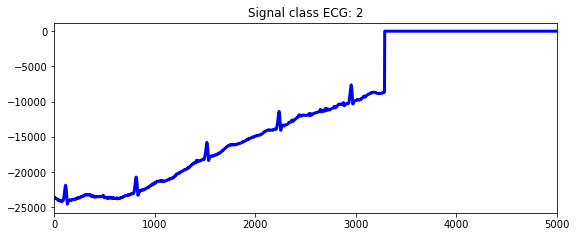

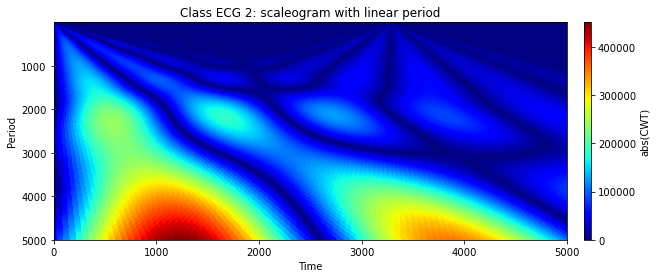

In [117]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 9466
nn_label = 1
signal_length = 5000
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_data[nn]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_data[nn], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {ecg_labels[nn_label]}")

# the scaleogram
scg.cws(ecg_data[nn][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {ecg_labels[nn_label]}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")